In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

import pyldpc as ldpc
import os
from tqdm.notebook import tqdm
import itertools
import scipy as sci
import scipy.sparse as sp
from scipy.stats import norm
import scipy

from utils_f import load_code

import os
import os.path
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from IB_Decoder_Classes import symmetric_sIB
from IB_Decoder_Classes import mutual_information as mutual_inf
from IB_Decoder_Classes import lin_sym_sIB

import pickle
import time
import scipy.io as sio

In [2]:
try:
    import pyopencl as cl
    import pyopencl.array as cl_array
    from pyopencl.clrandom import rand as clrand
except ImportError:
    Warning("PyOpenCl not installed")
import os
from mako.template import Template

# AWGN Channel Simulation

In [3]:
class AWGN_Channel_Quantizer:
    """Implementation of an information optimum quantizer unit assuming BPSK transmission.

    The quantizer is generated using the symmetric, sequential information bottleneck algorithm.
    This class supports OpenCL for faster quantization and even direct quantization and sample generation on the GPU
    (cf. quantize direct).
    Although it is theoretical correct to quantize directly, it is preferable to create a more realistic
    communication chain including an encoder and modulator in your system instead of using this direct quantization approach.

    Attributes:
        sigma_n2: noise variance corresponding to the desired design-Eb/N0 of the decoder
        AD_max_abs: limits of the quantizer
        cardinality_Y: number of steps used for the fine quantization of the input distribution of the quantizer
        cardinality_T: cardinality of the compression variable representing the quantizer output

        limits: borders of the quantizer regions
        y_vec: fine quantization of the input domain
        delta: spacing between two values in the quantized input domain (cf. y_vec)

        x_vec: position of the means of the involved Gaussians

    """
    def __init__(self, sigma_n2_, AD_max_abs_, cardinality_T_, cardinality_Y_, dont_calc = False):
        """Inits the quantizer class."""
        self.nror = 5
        self.limits = np.zeros(cardinality_T_)

        self.sigma_n2 = sigma_n2_
        self.cardinality_T = cardinality_T_
        self.cardinality_Y = cardinality_Y_
        self.AD_max_abs = AD_max_abs_

        self.y_vec = np.linspace(-self.AD_max_abs, +self.AD_max_abs, self.cardinality_Y)
        self.x_vec = np.array([-1, 1])
        self.delta = self.y_vec[1] - self.y_vec[0]
        if not dont_calc:
            self.calc_quanti()

    def calc_quanti(self):
        """Determines the information optimum quantizer for the given input distribution"""

        # calculate p_xy based on sigma_n2 and AD_max_abs;
        # init as normal with mean + 1
        p_y_given_x_equals_zero = norm.pdf(self.y_vec, loc=1, scale=np.sqrt(self.sigma_n2)) * self.delta

        # truncate t account for distortion introduced by the quantizer limits then
        p_y_given_x_equals_zero[-1] += self.gaussian_over_prob(self.AD_max_abs, 1)
        p_y_given_x_equals_zero[0] += self.gaussian_under_prob(-self.AD_max_abs, 1)

        # flip distribution, which realizes mean -1 or a transmitted bit = 1
        p_y_given_x_equals_one = p_y_given_x_equals_zero[::-1]

        self.p_xy = 0.5 * np.hstack((p_y_given_x_equals_zero[:,np.newaxis], p_y_given_x_equals_one[:,np.newaxis]))

        self.p_xy = self.p_xy / self.p_xy.sum() #normalize for munerical stability

        # run the symmetric sequential Information Bottleneck algorithm
        IB_class = symmetric_sIB(self.p_xy, self.cardinality_T, self.nror)
        IB_class.run_IB_algo()

        # store the results
        [self.p_t_given_y, self.p_x_given_t, self.p_t] = IB_class.get_results()

        # calculate
        # p(t | X = 0)=p(X=0 | t)
        # p(t) / p(X=0)
        self.p_x_given_t = self.p_x_given_t / self.p_x_given_t.sum(1)[:,np.newaxis]
        self.p_x_and_t = self.p_x_given_t * self.p_t[:,np.newaxis]
        p_t_given_x_equals_zero = self.p_x_and_t[:, 0] / 0.5

        self.cdf_t_given_x_equals_zero = np.append([0], np.cumsum(p_t_given_x_equals_zero))

        self.output_LLRs = np.log(self.p_x_and_t[:, 0] / self.p_x_and_t[:, 1])
        self.calc_limits()

    @classmethod
    def from_generated(cls, cdf_t_given_x_equals_zero_):
        cdf_t_given_x_equals_zero = cdf_t_given_x_equals_zero_
        return cls(cdf_t_given_x_equals_zero,)

    def gaussian_over_prob(self, x, mu):
        """Compensates the ignored probability mass caused by fixing the region to +- AD_abs_max."""

        prob = norm.sf((x-mu+self.delta/2)/np.sqrt(self.sigma_n2))
        return prob

    def gaussian_under_prob(self, x, mu):
        """Compensates the ignored probability mass caused by fixing the region to +- AD_abs_max."""

        prob = 1-self.gaussian_over_prob(x-self.delta,mu)
        return prob

    def calc_limits(self):
        """Calculates the limits of the quantizer borders"""

        for i in range(self.cardinality_T):
            cur_vec = (self.p_t_given_y[:, i] == 1).nonzero()
            self.limits[i] = self.y_vec[cur_vec[0].min()]

        self.limits[int(self.cardinality_T/2)] = 0
        #self.limits[-1]=self.AD_max_abs

    def quantize_direct(self, input_bits):
        """Direct quantization without the need of a channel in between since the inversion method is used.
        The clusters are directly sampled.
        """
        # create uniform samples
        rand_u = np.random.rand(input_bits.shape[0],input_bits.shape[1])

        # create samples ~ p(t | X = 0) using inversion method
        if input_bits.shape[1] > 1:
            output_integers = ((np.repeat(rand_u[:,:,np.newaxis], self.cardinality_T+1, axis=2)-self.cdf_t_given_x_equals_zero) > 0).sum(2)-1
            output_integers[input_bits.astype(bool)] = self.cardinality_T - 1 - output_integers[input_bits.astype(bool)]
        else:
            output_integers = ((rand_u - self.cdf_t_given_x_equals_zero) > 0).sum(1) - 1
            # "mirror" a sample, when the input bit is 1, otherwise do nothing.
            output_integers[input_bits.astype(bool)[:, 0]] = self.cardinality_T - 1 - output_integers[
            input_bits.astype(bool)[:, 0]]

        return output_integers

    def quantize_on_host(self,x):
        """Quantizes the received samples on the local machine"""
        if x.shape[1] > 1:
            cluster = ((np.repeat(x[:,:,np.newaxis], self.cardinality_T, axis=2)-self.limits) > 0).sum(2)-1
            cluster[cluster == -1] = 0
        else:
            cluster = np.sum((x - self.limits) > 0, 1) -1
            cluster[cluster==-1] = 0

        return cluster

    def init_OpenCL_quanti(self, N_var,msg_at_time,return_buffer_only=False):
        """Inits the OpenCL context and transfers all static data to the device"""

        self.context = cl.create_some_context()

        print(self.context.get_info(cl.context_info.DEVICES))
        path = os.path.split(os.path.abspath("__file__"))
        kernelsource = open(os.path.join(path[0], 'kernels_quanti_template.cl')).read()

        tpl = Template(kernelsource)
        rendered_tp = tpl.render(Nvar=N_var)

        self.program = cl.Program(self.context, str(rendered_tp)).build()

        self.return_buffer_only = return_buffer_only

        # Set up OpenCL
        self.queue = cl.CommandQueue(self.context)
        self.quantize = self.program.quantize
        self.quantize.set_scalar_arg_dtypes([np.int32, None, None, None])
        self.quantize_LLR = self.program.quantize_LLR
        self.quantize_LLR.set_scalar_arg_dtypes([np.int32, None, None, None,None])
        self.limit_buff = cl_array.to_device(self.queue, self.cdf_t_given_x_equals_zero.astype(np.float64))
        self.cluster_buff = cl_array.empty(self.queue, (N_var, msg_at_time), dtype=np.int32)
        self.LLR_buff = cl_array.empty(self.queue, (N_var, msg_at_time), dtype=np.float64)
        self.LLR_values_buff = cl_array.to_device(self.queue, self.output_LLRs.astype(np.float64))

    def quantize_OpenCL(self, x):
        """Quantizes the received distorted samples on the graphic card"""

        # Create OpenCL buffers

        x_buff = cl_array.to_device(self.queue,x.astype(np.float64) )
        limit_buff = cl_array.to_device(self.queue, self.limits.astype(np.float64))
        cluster_buff = cl_array.empty_like(x_buff.astype(np.int32))

        self.quantize(self.queue, x.shape, None, self.cardinality_T, x_buff.data, limit_buff.data, cluster_buff.data)
        self.queue.finish()

        if self.return_buffer_only:
            return cluster_buff
        else:
            clusters = cluster_buff.get()
            return clusters

    def quantize_direct_OpenCL(self,N_var,msg_at_time):
        """Direct quantization without the need of a channel in between since the inversion method is used.
        The clusters are directly sampled. In this scenario the all-zeros codeword is considered such that no data
        needs to be transferred to the graphic card.

        """

        #rand_u_buff = clrand(self.queue, (N_var,msg_at_time), dtype=np.float64, a=0, b=1)

        rand_u = np.random.rand(N_var,msg_at_time)

        # Create OpenCL buffers

        rand_u_buff = cl_array.to_device(self.queue,rand_u.astype(np.float64) )



        self.quantize(self.queue, (N_var,msg_at_time), None, self.cardinality_T+1, rand_u_buff.data,
                      self.limit_buff.data, self.cluster_buff.data)


        self.queue.finish()

        if self.return_buffer_only:
            return self.cluster_buff
        else:
            clusters = self.cluster_buff.get()
            return clusters

    def quantize_direct_OpenCL_LLR(self,N_var,msg_at_time):
        """ Returns the LLRs of the sampled cluster indices. These indices correspond to the quantized outputs which
        are found directly on the graphic card using the inversion method. """

        rand_u = np.random.rand(N_var,msg_at_time)

        # Create OpenCL buffers
        rand_u_buff = cl_array.to_device(self.queue,rand_u.astype(np.float64) )

        self.quantize_LLR(self.queue, (N_var,msg_at_time), None, self.cardinality_T+1, rand_u_buff.data,
                      self.limit_buff.data, self.LLR_values_buff.data, self.LLR_buff.data)

        self.queue.finish()

        if self.return_buffer_only:
            return self.LLR_buff
        else:
            LLRs = self.LLR_buff.get()
            return LLRs

# LDPC Transmitter

In [4]:
class LDPC_BPSK_Transmitter:

    def __init__(self, filename_H_,  msg_at_time=1):
        self.filename_H = filename_H_
        self.H_sparse = self.load_check_mat(self.filename_H)

        self.encoder = LDPCEncoder(self.filename_H)

        # analyze the H matrix and set all decoder variables
        self.set_code_parameters()

        self.data_len = (self.R_c * self.codeword_len).astype(int)

        self.last_transmitted_bits = []
        self.msg_at_time = msg_at_time

    def set_code_parameters(self):
        self.degree_checknode_nr = ((self.H_sparse).sum(1)).astype(np.int).A[:, 0]  # which check node has which degree?
        self.degree_varnode_nr = ((self.H_sparse).sum(0)).astype(np.int).A[0,
                                 :]  # which variable node has which degree?

        self.N_v = self.H_sparse.shape[1]  # How many variable nodes are present?
        self.N_c = self.H_sparse.shape[0]  # How many checknodes are present?

        self.d_c_max = self.degree_checknode_nr.max()
        self.d_v_max = self.degree_varnode_nr.max()

        self.codeword_len = self.H_sparse.shape[1]
        row_sum = self.H_sparse.sum(0).A[0, :]
        col_sum = self.H_sparse.sum(1).A[:, 0]
        d_v_dist_val = np.unique(row_sum)
        d_v_dist = np.zeros(int(d_v_dist_val.max()))

        for d_v in np.sort(d_v_dist_val).astype(np.int):
            d_v_dist[d_v - 1] = (row_sum == d_v).sum()
        d_v_dist = d_v_dist / d_v_dist.sum()

        d_c_dist_val = np.unique(col_sum)
        d_c_dist = np.zeros(int(d_c_dist_val.max()))

        for d_c in np.sort(d_c_dist_val).astype(np.int):
            d_c_dist[d_c - 1] = (col_sum == d_c).sum()

        d_c_dist = d_c_dist / d_c_dist.sum()
        nom = np.dot(d_v_dist, np.arange(d_v_dist_val.max()) + 1)
        den = np.dot(d_c_dist, np.arange(d_c_dist_val.max()) + 1)

        self.R_c = 1 - nom / den

    def alistToNumpy(self, lines):
        """Converts a parity-check matrix in AList format to a 0/1 numpy array. The argument is a
       list-of-lists corresponding to the lines of the AList format, already parsed to integers
        if read from a text file.
        The AList format is introduced on http://www.inference.phy.cam.ac.uk/mackay/codes/alist.html.
        This method supports a "reduced" AList format where lines 3 and 4 (containing column and row
        weights, respectively) and the row-based information (last part of the Alist file) are omitted.
        Example:
             >>> alistToNumpy([[3,2], [2, 2], [1,1,2], [2,2], [1], [2], [1,2], [1,2,3,4]])
            array([[1, 0, 1],
                  [0, 1, 1]])
        """

        nCols, nRows = lines[0]
        if len(lines[2]) == nCols and len(lines[3]) == nRows:
            startIndex = 4
        else:
            startIndex = 2
        matrix = np.zeros((nRows, nCols), dtype=np.int)
        for col, nonzeros in enumerate(lines[startIndex:startIndex + nCols]):
            for rowIndex in nonzeros:
                if rowIndex != 0:
                    matrix[rowIndex - 1, col] = 1

        return matrix

    def load_sparse_csr(self, filename):
        loader = np.load(filename)
        return sci.sparse.csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                              shape=loader['shape'])

    def load_check_mat(self, filename):
        if filename.endswith('.npy') or filename.endswith('.npz'):
            if filename.endswith('.npy'):
                H = np.load(filename)
                H_sparse = sci.sparse.csr_matrix(H)
            else:
                H_sparse = self.load_sparse_csr(filename)
        else:
            arrays = [np.array(list(map(int, line.split()))) for line in open(filename)]
            H = self.alistToNumpy(arrays)
            H_sparse = sci.sparse.csr_matrix(H)
        return H_sparse

    def transmit(self):

        uncoded_msgs = np.random.randint(0,2, (self.data_len, self.msg_at_time))

        #uncoded_msgs = np.zeros( (self.data_len, self.msg_at_time) )
        encoded_msgs = np.zeros((self.codeword_len, self.msg_at_time))


        for i in range(self.msg_at_time):

            encoded_msgs[:, i]=self.encoder.encode_c(uncoded_msgs[:, i])

        self.last_transmitted_bits = uncoded_msgs

        data = self.BPSK_mapping(encoded_msgs)

        return data

    def BPSK_mapping(self, X):

        data = np.ones((self.codeword_len, self.msg_at_time))
        data[X == 1] = -1

        return data

### Discrete density evolution class

In [22]:
print(type(DDE_inst))
print(type(DDE_inst.DDE_inst_data))

<class '__main__.AWGN_Discrete_Density_Evolution_class'>
<class 'dict'>


In [35]:
class Discrete_Density_Evolution_class:
    """This class enforces symmetric Trellis diagram by using the lin_sym_sIB class. See the documentation for further
    information about this Information Bottleneck algorithm
    Attributes:
    input parameter
        p_x_and_t_input             initial pdf p(x,t)
        cardinality_T_decoder_ops   message alphabet cardinality of the passed decoder messages
        d_v                         variable node degree
        d_c                         check node degree
        i_max                       number of iterations
    IB related parameters
        cardinality_T               number of clusters
        beta                        set to inf, due to deterministic mapping
        eps
        nror                        Number Of Runs, namely number of runs with different initial clusterings
    discrete DE parameters

    """
    PROBABILITY_MIN_JOINT_PDF = 1e-15
    PROBABILITY_MAX_JOINT_PDF = 0.5-1e-15

    def __init__(self, p_x_and_t_input_, cardinality_T_decoder_ops_, d_v_, d_c_, i_max_, nror_):
        # initialize parameters
        self.p_x_and_t_channel_init = p_x_and_t_input_
        #determine cardinalities
        self.cardinality_T_channel = self.p_x_and_t_channel_init.shape[0]
        self.cardinality_T_decoder_ops = cardinality_T_decoder_ops_

        # code related parameters
        self.d_v = d_v_
        self.d_c = d_c_

        # discrete DE paramters
        self.i_max = i_max_

        # IB parameters
        self.nror = nror_

        # generate look up tables (LUT) for all input combinations. Basically this is a linear remapping from a 2D space
        # onto a 1D vector. Due to the possible mismatch cardinality_T_channel != cardinality_T_decoder_ops, a specific
        # loop up table is generated for this case, since the number of possible input combination of a partial node
        # operation could vary.


        ###### ------ CHECK NODES Preallocation START ------ ######
        # As explained earlier due to the possible mismatch of cardinality_T_channel and cardinality_T_decoder_ops the
        # first iteration has to be treated separately. In this first iteration the first partial node operation at the
        # check node we have incoming messages from the channel taking cardinality_T_channel different values. The next
        # partial node operation gets an input vector containing the result of the first partial node operation being
        # cardinality cardinality_T_decoder_ops and a second input value from a variable node with cardinality_T_channel.
        # In the next iteration all incoming and outgoing messages can take only cardinality_T_decoder_ops values.

        # Preallocate LUTs

        # Case iter = 0
        self.all_two_input_combinations_first_partial_op_check_first_iter = np.hstack((
        np.kron(np.arange(self.cardinality_T_channel)[:, np.newaxis], np.ones([self.cardinality_T_channel, 1])),
        np.tile(np.arange(self.cardinality_T_channel)[:, np.newaxis], (self.cardinality_T_channel, 1)) ))

        # Case iter = 0, channel and cardinality_T_decoder_ops input
        self.all_two_input_combinations_other_partial_ops_check_first_iter = np.hstack((
        np.kron(np.arange(self.cardinality_T_decoder_ops)[:, np.newaxis], np.ones([self.cardinality_T_channel, 1])),
        np.tile(np.arange(self.cardinality_T_channel)[:, np.newaxis], (self.cardinality_T_decoder_ops, 1))))

        # Case iter >0, only cardinality_T_decoder_ops
        self.all_two_input_combinations_other_partial_ops_check = np.hstack((
        np.kron(np.arange(self.cardinality_T_decoder_ops)[:, np.newaxis], np.ones([self.cardinality_T_decoder_ops, 1])),
        np.tile(np.arange(self.cardinality_T_decoder_ops)[:, np.newaxis], (self.cardinality_T_decoder_ops, 1))))

        self.p_t_l_c_given_vec_y_l_c_collection = np.empty((self.i_max, self.d_c-2), dtype=object)
        self.p_x_l_c_given_t_l_c_collection = np.empty((self.i_max, self.d_c-2), dtype=object)
        self.sorted_vec_y_l_c_collection = np.empty((self.i_max, self.d_c-2), dtype=object)
        self.p_t_l_c_collection = np.empty((self.i_max, self.d_c-2), dtype=object)


        self.Trellis_checknodevector_a = \
            np.zeros(self.cardinality_T_channel**2 \
                     + (self.d_c-3)*self.cardinality_T_decoder_ops*self.cardinality_T_channel \
                     + (self.i_max-1)*self.cardinality_T_decoder_ops**2*(self.d_c-2))

        ###### ------ CHECK NODES Preallocation End ------ ######

        ###### ------ VARIABLE NODES Preallocation Start ------ ######

        # First message at the variable nodes is the quantized channel output. Consequently, this message can take
        # cardinality_T_channel values. The other incomming message are from check nodes and therefore are limited to
        # cardinality_T_decoder_ops values.

        self.all_two_input_combinations_first_partial_ops_var = np.hstack((
            np.kron(np.arange(self.cardinality_T_channel)[:, np.newaxis], np.ones([self.cardinality_T_decoder_ops, 1])),
            np.tile(np.arange(self.cardinality_T_decoder_ops)[:, np.newaxis], (self.cardinality_T_channel, 1))))


        self.all_two_input_combinations_other_partial_ops_var = np.hstack((
            np.kron(np.arange(self.cardinality_T_decoder_ops)[:, np.newaxis], np.ones([self.cardinality_T_decoder_ops, 1])),
            np.tile(np.arange(self.cardinality_T_decoder_ops)[:, np.newaxis], (self.cardinality_T_decoder_ops, 1))))

        self.p_t_l_v_given_vec_y_l_v_collection = np.empty((self.i_max, self.d_v), dtype=object)
        self.p_x_l_v_given_t_l_v_collection = np.empty((self.i_max, self.d_v), dtype=object)
        self.sorted_vec_y_l_v_collection = np.empty((self.i_max, self.d_v), dtype=object)
        self.p_t_l_v_collection = np.empty((self.i_max, self.d_v), dtype=object)


        self.Trellis_varnodevector_a = \
            np.zeros( (self.i_max) * (self.cardinality_T_channel * self.cardinality_T_decoder_ops
                                      + (self.d_v - 1) * self.cardinality_T_decoder_ops ** 2))

        ###### ------ VARIABLE NODES Preallocation END ------ ######

        # preallocate vectors for mutual information results
        self.MI_T_dvm1_v_X_dvm1_v = np.zeros(self.i_max)
        self.MI_Y_dvm1_v_X_dvm1_v = np.zeros(self.i_max)
        self.mutual_inf_gain_matrix = np.zeros((self.i_max,self.d_v) )

    def check_node_density_evolution(self, iteration, p_x_lminus1_c_and_t_lminus1_c, p_b_lplus1_c_and_y_lplus1_c):
        print("check_node_density_evolution"+str(iteration))
        for w in range(self.d_c - 2):
            p_x_l_c_and_vec_y_l_c_lin = self.checknode_in_joint_pdf_y_lin(p_x_lminus1_c_and_t_lminus1_c,
                                                                          p_b_lplus1_c_and_y_lplus1_c)

            # run Information Bottleneck algorithm on p_x_l_c_and_vec_y_l_c_lin
            IB_instance = lin_sym_sIB(self.numerical_quard(p_x_l_c_and_vec_y_l_c_lin),
                                      self.cardinality_T_decoder_ops,
                                      self.nror)

            IB_instance.run_IB_algo()

            # get results and feed back
            p_t_l_c_given_vec_y_l_c, p_x_lminus1_c_given_t_lminus1_c, p_t_lm1_c = IB_instance.get_results()
            p_x_lminus1_c_and_t_lminus1_c = p_x_lminus1_c_given_t_lminus1_c * p_t_lm1_c[:,np.newaxis]


            IB_instance.display_MIs(short=True)

            # save message mappings for the check nodes explicitly in  cell array
            self.p_t_l_c_given_vec_y_l_c_collection[iteration, w] = p_t_l_c_given_vec_y_l_c
            self.p_x_l_c_given_t_l_c_collection[iteration, w] = p_x_lminus1_c_given_t_lminus1_c
            self.p_t_l_c_collection[iteration, w] = p_t_lm1_c

            if iteration == 0 and w == 0:
                self.sorted_vec_y_l_c_collection[iteration, w] = \
                    self.all_two_input_combinations_first_partial_op_check_first_iter
            if iteration == 0 and w > 0:
                self.sorted_vec_y_l_c_collection[iteration, w] = \
                    self.all_two_input_combinations_other_partial_ops_check_first_iter
            if iteration > 0:

                self.sorted_vec_y_l_c_collection[iteration, w] = self.all_two_input_combinations_other_partial_ops_check

        return p_x_lminus1_c_and_t_lminus1_c

    def variable_node_density_evolution(self, iteration, p_x_lminus1_c_and_t_lminus1_c):
        print("variable_node_density_evolution number"+str(iteration))

        # The first message is from the channel and the second message is a message from the other nodes per definition
        p_b_lplus1_v_and_y_lplus1_v = self.p_x_and_t_channel_init # channel
        p_x_lminus1_v_and_t_lminus1_v = p_x_lminus1_c_and_t_lminus1_c # output of DE for the check nodes

        p_x_l_v_and_vec_y_l_v_lin = self.varnode_in_joint_pdf_y_lin(p_b_lplus1_v_and_y_lplus1_v,
                                                                    p_x_lminus1_v_and_t_lminus1_v)


        # run Information Bottleneck algorithm on p_x_l_v_and_vec_y_l_v_lin
        IB_instance = lin_sym_sIB(self.numerical_quard(p_x_l_v_and_vec_y_l_v_lin),
                                  self.cardinality_T_decoder_ops,
                                  self.nror)

        IB_instance.run_IB_algo()

        # get results and feed back
        p_t_l_v_given_vec_y_l_v, p_x_lminus1_v_given_t_lminus1_v, p_t_lm1_v = IB_instance.get_results()

        p_x_lminus1_v_and_t_lminus1_v = p_x_lminus1_v_given_t_lminus1_v * p_t_lm1_v[:, np.newaxis]

        IB_instance.display_MIs(short=True)
        self.mutual_inf_gain_matrix[iteration,0] = IB_instance.get_mutual_inf()[0]

        # save message mappings for the variable nodes explicitly in  cell array
        self.p_t_l_v_given_vec_y_l_v_collection[iteration, 0] = p_t_l_v_given_vec_y_l_v
        self.p_x_l_v_given_t_l_v_collection[iteration, 0] = p_x_lminus1_v_given_t_lminus1_v
        self.p_t_l_v_collection[iteration, 0] = p_t_lm1_v


        self.sorted_vec_y_l_v_collection[iteration, 0] = self.all_two_input_combinations_first_partial_ops_var

        # the rest of the message pdfs are all from check nodes
        p_b_lplus1_v_and_y_lplus1_v = p_x_lminus1_c_and_t_lminus1_c

        for w in range(1, self.d_v - 1):
            p_x_l_v_and_vec_y_l_v_lin = self.varnode_in_joint_pdf_y_lin(p_x_lminus1_v_and_t_lminus1_v,
                                                                        p_b_lplus1_v_and_y_lplus1_v)

            # run Information Bottleneck algorithm on p_x_l_v_and_vec_y_l_v_lin
            IB_instance = lin_sym_sIB(self.numerical_quard(p_x_l_v_and_vec_y_l_v_lin),
                                      self.cardinality_T_decoder_ops,
                                      self.nror)

            IB_instance.run_IB_algo()

            # get results and feed back
            p_t_l_v_given_vec_y_l_v, p_x_lminus1_v_given_t_lminus1_v, p_t_lm1_v = IB_instance.get_results()

            p_x_lminus1_v_and_t_lminus1_v = p_x_lminus1_v_given_t_lminus1_v * p_t_lm1_v[:, np.newaxis]

            IB_instance.display_MIs(short=True)
            self.mutual_inf_gain_matrix[iteration,w] = IB_instance.get_mutual_inf()[0] - self.mutual_inf_gain_matrix[iteration,:].sum()

            # save message mappings for the variable nodes explicitly in  cell array
            self.p_t_l_v_given_vec_y_l_v_collection[iteration, w] = p_t_l_v_given_vec_y_l_v
            self.p_x_l_v_given_t_l_v_collection[iteration, w] = p_x_lminus1_v_given_t_lminus1_v
            self.p_t_l_v_collection[iteration, w] = p_t_lm1_v

            self.sorted_vec_y_l_v_collection[iteration, w] = self.all_two_input_combinations_other_partial_ops_var

        de_varnode_out = p_x_lminus1_v_and_t_lminus1_v / p_x_lminus1_v_and_t_lminus1_v.sum()

        # and run the IB algorithm for the last time to create the message mappings of the decision mapping for the
        # variable nodes
        p_x_l_v_and_vec_y_l_v_lin = self.varnode_in_joint_pdf_y_lin(p_x_lminus1_v_and_t_lminus1_v,
                                                                  p_b_lplus1_v_and_y_lplus1_v)


        IB_instance = lin_sym_sIB(self.numerical_quard(p_x_l_v_and_vec_y_l_v_lin),
                                  self.cardinality_T_decoder_ops,
                                  self.nror)

        IB_instance.run_IB_algo()

        # get results and save
        p_t_l_v_given_vec_y_l_v, p_x_lminus1_v_given_t_lminus1_v, p_t_lm1_v = IB_instance.get_results()

        IB_instance.display_MIs(short=True)
        self.mutual_inf_gain_matrix[iteration,-1] = IB_instance.get_mutual_inf()[0] - \
                                                    self.mutual_inf_gain_matrix[iteration,:].sum()
        # and save the resulting message mapping
        self.p_t_l_v_given_vec_y_l_v_collection[iteration, -1] = p_t_l_v_given_vec_y_l_v
        self.p_x_l_v_given_t_l_v_collection[iteration, -1] = p_x_lminus1_v_given_t_lminus1_v
        self.p_t_l_v_collection[iteration, -1] = p_t_lm1_v

        # finally store I(T_(d_v - 1} ^ v, X{d_v - 1} ^ v)
        self.MI_T_dvm1_v_X_dvm1_v[iteration], self.MI_Y_dvm1_v_X_dvm1_v[iteration] = IB_instance.get_mutual_inf()

        self.sorted_vec_y_l_v_collection[iteration, -1] = self.all_two_input_combinations_other_partial_ops_var

        return de_varnode_out

    def run_discrete_Density_Evolution(self):
        """This function combines all subroutines to implement discrete density evolution"""

        #  in the first iteration all incoming messages are directly from the channel
        p_x_lminus1_c_and_t_lminus1_c = self.p_x_and_t_channel_init / self.p_x_and_t_channel_init.sum()
        p_b_lplus1_c_and_y_lplus1_c = self.p_x_and_t_channel_init / self.p_x_and_t_channel_init.sum()

        # create theIB_calc object(init values are arbitrary, in density evolution loop, the member function init()
        # is called to set up the object properly, but we do not have a standard constructor in this class )

        self.ext_mi_varnode_in_iter = np.empty(self.i_max+1)
        self.ext_mi_checknode_in_iter = np.empty(self.i_max)

        self.ext_mi_varnode_in_iter[0] = mutual_inf(self.p_x_and_t_channel_init)

        for i in range(self.i_max):

            # check node density evolution
            de_checknode_out = self.check_node_density_evolution(i, p_x_lminus1_c_and_t_lminus1_c, p_b_lplus1_c_and_y_lplus1_c)
            self.ext_mi_checknode_in_iter[i] = mutual_inf(de_checknode_out)

            # variable node density evolution
            de_varnode_out = self.variable_node_density_evolution(i, de_checknode_out)
            self.ext_mi_varnode_in_iter[i+1] = mutual_inf(de_varnode_out)

            # set feed back variables to the varnode density evolution
            # normalize for stability
            p_b_lplus1_c_and_y_lplus1_c = de_varnode_out
            p_x_lminus1_c_and_t_lminus1_c = de_varnode_out


        # calculate the Trellis vector vec_a for the checknodes for all partial steps in the first decoder iteration
        # first partial node operation:
        # @param iteration: denotes the iteration
        # @param l: indicates teh partial node operation index

        l=0
        self.Trellis_checknodevector_a[:(l+1)*self.cardinality_T_channel**2] = \
            np.argmax(self.p_t_l_c_given_vec_y_l_c_collection[0, l], axis=1).astype(int)

        # and now for the other partial node operations of the first iteration, where l>0
        for l in range(1, self.d_c-2):
            # the offset marks the jump in address for this iteration
            offset = 1*self.cardinality_T_channel**2+(l-1)*self.cardinality_T_channel*self.cardinality_T_decoder_ops

            # length denotes the number new samples, which are filled in Trellis_Trellis_checknodevector_a
            length = self.cardinality_T_channel * self.cardinality_T_decoder_ops

            self.Trellis_checknodevector_a[offset:offset+length] = \
                np.argmax(self.p_t_l_c_given_vec_y_l_c_collection[0, l], axis=1).astype(int)


        # calc for iterations > 0
        initial_offset = 1*self.cardinality_T_channel**2+(self.d_c-3)*self.cardinality_T_channel*self.cardinality_T_decoder_ops
        for iteration in range(1, self.i_max):
            iter_offset = (iteration-1) * (self.d_c-2) * self.cardinality_T_decoder_ops**2
            for l in range(self.d_c - 2):
                offset = initial_offset + iter_offset + l*self.cardinality_T_decoder_ops**2
                length = self.cardinality_T_decoder_ops**2

                self.Trellis_checknodevector_a[offset:offset + length] = \
                    np.argmax(self.p_t_l_c_given_vec_y_l_c_collection[iteration, l], axis=1).astype(int)


        # Trellis vector for variable nodes
        for iteration in range(self.i_max):
            l = 0
            iter_offset = iteration * (self.cardinality_T_channel * self.cardinality_T_decoder_ops +
                                      (self.d_v - 1) * self.cardinality_T_decoder_ops ** 2)

            length = self.p_t_l_v_given_vec_y_l_v_collection[iteration, l].shape[0]

            self.Trellis_varnodevector_a[iter_offset:iter_offset + length] = \
                np.argmax(self.p_t_l_v_given_vec_y_l_v_collection[iteration, l], axis=1).astype(int)

            offset_after_first_op = iter_offset+length

            for l in range(1, self.d_v):
                offset = offset_after_first_op + (l - 1) * (self.cardinality_T_decoder_ops ** 2)
                length = self.cardinality_T_decoder_ops ** 2
                self.Trellis_varnodevector_a[offset:offset+length] = \
                    np.argmax(self.p_t_l_v_given_vec_y_l_v_collection[iteration, l], axis=1).astype(int)

    def checknode_in_joint_pdf_y_lin(self, p_t_lminus1_c_and_x_lminus1_c, p_y_lplus1_c_and_b_lplus1_c ):
        """ This function calculates the joint pdf p(vec_y_l ^ c, x_l ^ c) that is needed for the density evolution. The
        result is  a matrix. Each row corresponds to a linearized vector vec_y_l ^ c

        Please note that according to the
        paper the vector vec_y_l ^ c = [t_{l - 1} ^ c, y_{l + 1} ^ c] and that the order is extremely important, because
        a linear coordinate is calculated from this vector by the rule
        vec_y_lin = | \mathcal {Y} ^ c | t_ {l - 1} ^ c + y_  {l + 1} ^ c
        Args:
            :param p_t_lminus1_c_and_x_lminus1_c:   the density p(t_lm1_c,x_lm1_c)
            :param p_y_lplus1_c_and_b_lplus1_c:   the density p(y_lp1_c,b_lp1_c)
        Return
            :return p_x_c_and_y_vec_c:
        """

        # determine the cardinality of the first input. Referring to the paper this is the message entering from the top
        cardinality_Y_i_first_in = p_t_lminus1_c_and_x_lminus1_c.shape[0]
        cardinality_Y_i_second_in = p_y_lplus1_c_and_b_lplus1_c.shape[0]
        cardinality_vec_y_l = cardinality_Y_i_first_in*cardinality_Y_i_second_in

        p_x_c_and_y_vec_c = np.zeros((cardinality_vec_y_l, 2))
        p_x_c_and_y_vec_c2 = np.zeros((cardinality_vec_y_l, 2))

        # In the following the sum is evaluated. There exist two case where x^c can be 0 or 1. Furthermore the \oplus
        # sum of b_0 and b_1 results in each of the previously mentioned cases, on two different ways. These are denoted
        # as part 1 and part 2. The sum of these parts equals the result for either x^c=0 or 1.

        y_lp1_vec = np.kron(np.arange(cardinality_Y_i_second_in)[:, np.newaxis], np.ones([cardinality_Y_i_first_in, 1])).astype(int)
        t_lm1_vec = np.tile(np.arange(cardinality_Y_i_first_in)[:, np.newaxis], (cardinality_Y_i_second_in,1))

        # case x ^ c = 0, where x ^ c = b_0 ^ c \oplus b_1 ^ c
        # case b_0 ^ c = 0 b_1 ^ c = 0 ,case b_0 ^ c = 1 b_1 ^ c = 1
        part10 = p_y_lplus1_c_and_b_lplus1_c[y_lp1_vec, :] * p_t_lminus1_c_and_x_lminus1_c[t_lm1_vec, :]

        p_x_c_and_y_vec_c[cardinality_Y_i_second_in * t_lm1_vec + y_lp1_vec, 0] = part10.sum(2) #+ part20

        # case x ^ c = 1, where x ^ c = b_0 ^ c \oplus b_1 ^ c
        # case b_0 ^ c = 0 b_1 ^ c = 1 , case b_0 ^ c = 1  b_1 ^ c = 0
        part11 = p_y_lplus1_c_and_b_lplus1_c[y_lp1_vec, :] * p_t_lminus1_c_and_x_lminus1_c[t_lm1_vec, ::-1]

        p_x_c_and_y_vec_c[cardinality_Y_i_second_in * t_lm1_vec + y_lp1_vec, 1] = part11.sum(2)

        return p_x_c_and_y_vec_c

    def varnode_in_joint_pdf_y_lin(self, p_t_lminus1_v_and_x_lminus1_v, p_y_lplus1_v_and_b_lplus1_v):
        """ This function calculates the joint pdf p(vec_y_l ^ v, x_l ^ v) that is needed for the density evolution. The
        result is  a matrix. Each row corresponds to a linearized vector vec_y_l ^ v

        Please note that according to the
        paper the vector vec_y_l ^ c = [t_{l - 1} ^ v, y_{l + 1} ^ v] and that the order is extremely important, because
        a linear coordinate is calculated from this vector by the rule
        vec_y_lin = | \mathcal {Y} ^ v | t_ {l - 1} ^ v + y_  {l + 1} ^ v
        Args:
            :param p_t_lminus1_v_and_x_lminus1_v:   the density p(t_lm1_v,x_lm1_v)
            :param p_y_lplus1_v_and_b_lplus1_v:   the density p(y_lp1_v,b_lp1_v)
        Return
            :return p_x_v_and_y_vec_v:
        """

        # determine the cardinality of the first input. Referring to the paper this is the message entering from the top
        cardinality_Y_i_first_in = p_t_lminus1_v_and_x_lminus1_v.shape[0]
        cardinality_Y_i_second_in = p_y_lplus1_v_and_b_lplus1_v.shape[0]
        cardinality_vec_y_l = cardinality_Y_i_first_in * cardinality_Y_i_second_in

        p_x_v_and_y_vec_v = np.zeros((cardinality_vec_y_l, 2))

        # In the following the sum is evaluated. There exist two case where x^c can be 0 or 1. Furthermore the \oplus
        # sum of b_0 and b_1 results in each of the previously mentioned cases, on two different ways. These are denoted
        # as part 1 and part 2. The sum of these parts equals the result for either x^c=0 or 1.

        y_lp1_vec = np.kron(np.arange(cardinality_Y_i_second_in)[:, np.newaxis],
                            np.ones([cardinality_Y_i_first_in, 1])).astype(int)
        t_lm1_vec = np.tile(np.arange(cardinality_Y_i_first_in)[:, np.newaxis], (cardinality_Y_i_second_in, 1))

        # case x ^ c = 0, where x ^ c = b_0 ^ c \oplus b_1 ^ c
        # case b_0 ^ c = 0 b_1 ^ c = 0 ,case b_0 ^ c = 1 b_1 ^ c = 1
        part10 = 2 * p_y_lplus1_v_and_b_lplus1_v[y_lp1_vec, 0] * p_t_lminus1_v_and_x_lminus1_v[t_lm1_vec, 0]

        p_x_v_and_y_vec_v[cardinality_Y_i_second_in * t_lm1_vec + y_lp1_vec, 0] = part10

        # case x ^ c = 1, where x ^ c = b_0 ^ c \oplus b_1 ^ c
        # case b_0 ^ c = 0 b_1 ^ c = 1 , case b_0 ^ c = 1  b_1 ^ c = 0
        part11 = 2 * p_y_lplus1_v_and_b_lplus1_v[y_lp1_vec, 1] * p_t_lminus1_v_and_x_lminus1_v[t_lm1_vec, 1]

        p_x_v_and_y_vec_v[cardinality_Y_i_second_in * t_lm1_vec + y_lp1_vec, 1] = part11

        return p_x_v_and_y_vec_v

    def numerical_quard(self, pdf):
        """Function to avoid numerical instabilities."""
        limited_pdf = pdf
        limited_pdf[limited_pdf <= self.PROBABILITY_MIN_JOINT_PDF] = self.PROBABILITY_MIN_JOINT_PDF
        limited_pdf[limited_pdf >= self.PROBABILITY_MAX_JOINT_PDF] = self.PROBABILITY_MAX_JOINT_PDF
        limited_pdf = limited_pdf / limited_pdf.sum()
        return limited_pdf

    def visualize_mi_evolution(self):
        plt.plot(range(self.i_max), self.MI_T_dvm1_v_X_dvm1_v)
        plt.title("mutual information of output I(X;T)")
        plt.xlabel("iteration")
        plt.legend()
        plt.show()


# AWGN Discrete Density Evolution

In [36]:
class AWGN_Discrete_Density_Evolution_class:
    """ Generates a discrete LDPC decoder for a AWGN channel and a regular LDPC code for a certain design-Eb/N0.

    The assumed modulation is BPSK which is considered in the quantizer design.
    Attributes:
        sigma_n2: noise variance corresponding to the desired design-Eb/N0 of the decoder
        AD_max_abs: limits of the quantizer
        cardinality_Y_channel: number of steps used for the fine quantization of the input distribution of the quantizer
        cardinality_T_channel: cardinality of the compression variable representing the quantizer output

        cardinality_T_decoder_ops: cardinality of the compression variables inside the decoder

        d_c: check node degree
        d_v: variable node degree

        imax: maximum number of iterations
        nror: number of runs of the Information Bottleneck algorithm

        Trellis_checknodevector_a:  vectorized version of the trellis which holds the resulting outputs for a certain
                                    input and iteration at a check node
        Trellis_varnodevector_a:  vectorized version of the trellis which holds the resulting outputs for a certain
                                    input and iteration at a variable node
    """
    def __init__(self, sigma_n2_, AD_max_abs_,cardinality_Y_channel_, cardinality_T_channel_,
                 cardinality_T_decoder_ops_,d_v_, d_c_, i_max_, nror_):
        """Inits the AWGN_Discrete_Density_Evolution_class with the following arguments

        Args:
            sigma_n2_: noise variance corresponding to the desired design-Eb/N0 of the decoder
            AD_max_abs_: limits of the quantizer
            cardinality_Y_channel_: number of steps used for the fine quantization of the input distribution of the quantizer
            cardinality_T_channel_: cardinality of the compression variable representing the quantizer output

            cardinality_T_decoder_ops_: cardinality of the compression variables inside the decoder

            d_c_: check node degree
            d_v_: variable node degree

            i_max_: maximum number of iterations
            nror_: number of runs of the Information Bottleneck algorithm
        """
        # copy input arguments to class attributes
        self.sigma_n2 = sigma_n2_
        self.AD_max_abs = AD_max_abs_

        self.cardinality_Y_channel = cardinality_Y_channel_
        self.cardinality_T_channel = cardinality_T_channel_
        self.cardinality_T_decoder_ops = cardinality_T_decoder_ops_

        self.d_v = d_v_
        self.d_c = d_c_

        R_c = 1 - self.d_v / self.d_c
        if R_c > 0:
            self.EbN0 = -10 * np.log10(self.sigma_n2 * 2 * R_c)

        self.imax = i_max_
        self.nror = nror_

        self.build_quantizer()


        self.Trellis_checknodevector_a = 0
        self.Trellis_varnodevector_a = 0

    def set_code_parameters(self):
        """Analysis of the given parity check matrix.
        Determines node-degree distribution, edge-degree distribution and code rate
        """
        self.degree_checknode_nr = ((self.H_sparse).sum(1)).astype(np.int).A[:, 0]  # which check node has which degree?
        self.degree_varnode_nr = ((self.H_sparse).sum(0)).astype(np.int).A[0,
                                 :]  # which variable node has which degree?

        self.N_v = self.H_sparse.shape[1]  # How many variable nodes are present?
        self.N_c = self.H_sparse.shape[0]  # How many checknodes are present?

        self.d_c_max = self.degree_checknode_nr.max()
        self.d_v_max = self.degree_varnode_nr.max()

        self.codeword_len = self.H_sparse.shape[1]
        row_sum = self.H_sparse.sum(0).A[0, :]
        col_sum = self.H_sparse.sum(1).A[:, 0]
        d_v_dist_val = np.unique(row_sum)
        d_v_dist = np.zeros(int(d_v_dist_val.max()))

        for d_v in np.sort(d_v_dist_val).astype(np.int):
            d_v_dist[d_v - 1] = (row_sum == d_v).sum()

        d_v_dist = d_v_dist / d_v_dist.sum()

        d_c_dist_val = np.unique(col_sum)
        d_c_dist = np.zeros(int(d_c_dist_val.max()))

        for d_c in np.sort(d_c_dist_val).astype(np.int):
            d_c_dist[d_c - 1] = (col_sum == d_c).sum()

        d_c_dist = d_c_dist / d_c_dist.sum()

        nom = np.dot(d_v_dist, np.arange(d_v_dist_val.max()) + 1)
        den = np.dot(d_c_dist, np.arange(d_c_dist_val.max()) + 1)

        self.lambda_vec = convert_node_to_edge_degree(d_v_dist)
        self.rho_vec = convert_node_to_edge_degree(d_c_dist)

        self.R_c = 1 - nom / den

    def alistToNumpy(self, lines):
        """Converts a parity-check matrix in AList format to a 0/1 numpy array. The argument is a
        list-of-lists corresponding to the lines of the AList format, already parsed to integers
        if read from a text file.
        The AList format is introduced on http://www.inference.phy.cam.ac.uk/mackay/codes/alist.html.
        This method supports a "reduced" AList format where lines 3 and 4 (containing column and row
        weights, respectively) and the row-based information (last part of the Alist file) are omitted.
        Example:
             >>> alistToNumpy([[3,2], [2, 2], [1,1,2], [2,2], [1], [2], [1,2], [1,2,3,4]])
            array([[1, 0, 1],
                  [0, 1, 1]])
        """

        nCols, nRows = lines[0]
        if len(lines[2]) == nCols and len(lines[3]) == nRows:
            startIndex = 4
        else:
            startIndex = 2
        matrix = np.zeros((nRows, nCols), dtype=np.int)
        for col, nonzeros in enumerate(lines[startIndex:startIndex + nCols]):
            for rowIndex in nonzeros:
                if rowIndex != 0:
                    matrix[rowIndex - 1, col] = 1

        return matrix

    def load_sparse_csr(self, filename):
        """Performs loading of a sparse parity check matrix which is stored in a *.npy file."""
        loader = np.load(filename)
        return sci.sparse.csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                                     shape=loader['shape'])

    def load_check_mat(self, filename):
        """Performs loading of a predefined parity check matrix."""
        if filename.endswith('.npy') or filename.endswith('.npz'):
            if filename.endswith('.npy'):
                H = np.load(filename)
                H_sparse = sci.sparse.csr_matrix(H)
            else:
                H_sparse = self.load_sparse_csr(filename)
        else:
            arrays = [np.array(list(map(int, line.split()))) for line in open(filename)]
            H = self.alistToNumpy(arrays)
            H_sparse = sci.sparse.csr_matrix(H)
        return H_sparse

    def build_quantizer(self):
        """Generates instance of a quantizer for BPSK and an AWGN channel for the given characteristics."""
        quanti = AWGN_Channel_Quantizer(self.sigma_n2,self.AD_max_abs,self.cardinality_T_channel,self.cardinality_Y_channel)
        self.p_x_and_t_input = quanti.p_x_and_t

    def run_discrete_density_evolution(self):
        """Performs the discrete density evolution using the input distributions obtained from the quantizer.
        The resulting trellis diagram is stored in a vector that can be used for the real decoder later.
        """
        DDE_inst = Discrete_Density_Evolution_class(self.p_x_and_t_input, self.cardinality_T_decoder_ops,
                               self.d_v, self.d_c, self.imax, self.nror)

        DDE_inst.run_discrete_Density_Evolution()
        DDE_inst.visualize_mi_evolution()
        self.Trellis_checknodevector_a = DDE_inst.Trellis_checknodevector_a
        self.Trellis_varnodevector_a = DDE_inst.Trellis_varnodevector_a

        self.DDE_inst_data = DDE_inst.__dict__

    def save_config(self,text=''):
        """Saves the instance."""
        #timestr = time.strftime("%Y%m%d-%H%M%S")
        timestr =''

        output = open('decoder_config_EbN0_gen_' + str(self.EbN0) + '_' + str(
            self.cardinality_T_decoder_ops) + timestr + text + '.pkl', 'wb')

        # Pickle dictionary using protocol -1.
        pickle.dump(self.__dict__, output, protocol=-1)

### Create decoder for Regular LDPC

Run: [######################################################################] 100.0% 5 / 5    

check_node_density_evolution0
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.3451520870932966
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.21026602998227484
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.12975265510153106
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.08052946769739432
variable_node_density_evolution number0
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.6051430482308714
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.6316220081453163
Run: [######################################################################] 100

Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.6538592880506142
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.7160608268285873
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.7662554722244215
check_node_density_evolution9
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.5219045339231456
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.3852283660796149
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.28631045671903754
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.21332703480493795
variable_node_density_evolution number9
Run: [###############################################

Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.40682917182407596
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.30676012481080217
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.23133192891337767
variable_node_density_evolution number17
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.6625329347126868
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.7299885351491827
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.7828918766731179
check_node_density_evolution18
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.5409186734467906
Run: [############################################

Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.7319356015742111
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.7851405860861191
check_node_density_evolution26
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.5451923979746243
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.40964041778177485
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.3101608329018236
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.23546556065618007
variable_node_density_evolution number26
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.6643602812839626
Run: [#############################################

Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.4152337872905605
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.31557813001137625
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.2391384889367193
variable_node_density_evolution number34
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.6655464583933776
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.7346049511532073
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.7885103866487124
check_node_density_evolution35
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.5469597011532179
Run: [##############################################

Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.7373914074659117
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.7917415350293957
check_node_density_evolution43
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.5522730723689504
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.4168034584577376
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.3176297471064314
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.24302292374293813
variable_node_density_evolution number43
Run: [######################################################################] 100.0% 4 / 4    

MI_XT_s=  0.6675657118533365
Run: [##############################################

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




MI_XT_s=  0.7899923766631115


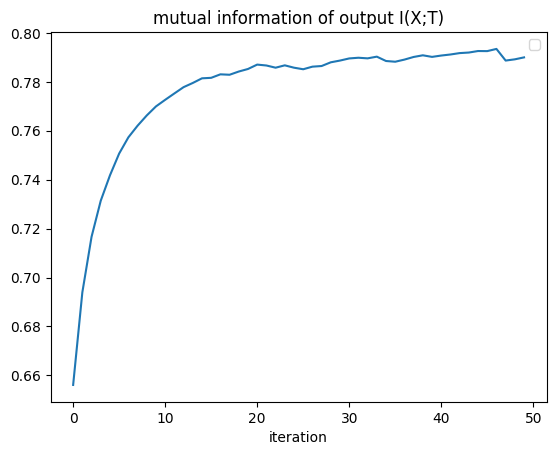

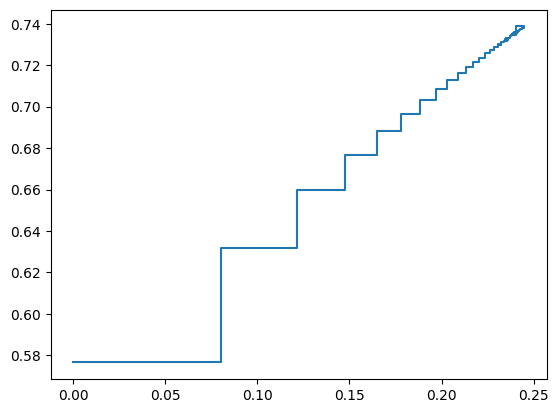

In [44]:
EbN0_dB_mapping_gen = 1.2


# set quantizer limits
AD_Max_abs = 3


cardinality_Y_channel = 2000
cardinality_T_channel = 16
cardinality_T_decoder_ops = 16
i_max = 50
nror = 4

# set code related parameters
d_v = 3
d_c = 6

R_c = 1-d_v/d_c    # code rate

sigma_n2 = 10**(-EbN0_dB_mapping_gen/10) / (2*R_c)

# generate decoder config
DDE_inst = AWGN_Discrete_Density_Evolution_class(sigma_n2, AD_Max_abs, cardinality_Y_channel, cardinality_T_channel,
               cardinality_T_decoder_ops, d_v, d_c, i_max, nror )
DDE_inst.run_discrete_density_evolution()


# generate trajectory

x_vec = np.zeros(2*i_max-1)
y_vec = np.zeros(2*i_max-1)

x_vec[0] = 0
y_vec[0] = DDE_inst.DDE_inst_data['ext_mi_varnode_in_iter'][0]


for i in range(1,i_max):
    x_vec[2*i-1] = DDE_inst.DDE_inst_data['ext_mi_checknode_in_iter'][i-1]
    y_vec[2*i-1] = y_vec[2*i-2]

    x_vec[2 * i] = x_vec[2*i-1]
    y_vec[2 * i] = DDE_inst.DDE_inst_data['ext_mi_varnode_in_iter'][i]

plt.plot(x_vec,y_vec)

plt.show()

In [45]:
#DDE_inst.save_config()

In [46]:
np.seterr(all='raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

## Discrete LDPC decoder class

In [47]:
import pyopencl as cl
import pyopencl.array as cl_array
from mako.template import Template
from pyopencl.reduction import get_sum_kernel

In [48]:
class Discrete_LDPC_Decoder_class:
    """This class uses the results of Discrete Density Evolution to set up LDPC decoder that purely works on
       lookups of integers.
    Attributes:
        H                           the parity check matrix of the Low-Density-Parity Check Code
        i_max                       the number of iteration, that should be performed by the decoder
        cardinality_Y_channel       the resolution of the continuous channel (typically a large number)
        cardinality_T_channel       number of clusters of the channel quantizer
        cardinality_T_decoder_ops   number of clusters used by the decoder, typically similar to cardinality_T_channel
    """

    def __init__(self, filename, imax_, cardinality_T_channel_,
                 cardinality_T_decoder_ops_, Trellis_checknode_vector_a_, Trellis_varnode_vector_a_,msg_at_time_):
        # initialize parameters
        self.H = self.load_check_mat(filename)
        self.imax = imax_

        # Quantizer parameters
        self.cardinality_T_channel = cardinality_T_channel_

        # Discrete DE related
        self.cardinality_T_decoder_ops = cardinality_T_decoder_ops_
        self.Trellis_checknode_vector_a = Trellis_checknode_vector_a_.astype(int)
        self.Trellis_varnode_vector_a = Trellis_varnode_vector_a_.astype(int)

        # analyze the H matrix and set all decoder variables
        self.degree_checknode_nr = (self.H).sum(1) # which check node has which degree?
        self.degree_varnode_nr = (self.H).sum(0) # which variable node has which degree?
        self.N_v = self.H.shape[1]  # How many variable nodes are present?
        self.N_c = self.H.shape[0] # How many checknodes are present?

        self.msg_at_time = msg_at_time_
        self.map_node_connections()

    def update_trellis_vectors(self,Trellis_checknode_vector_a_, Trellis_varnode_vector_a_):
        self.Trellis_checknode_vector_a = Trellis_checknode_vector_a_.astype(int)
        self.Trellis_varnode_vector_a = Trellis_varnode_vector_a_.astype(int)

    def alistToNumpy(self, lines):
        """Converts a parity-check matrix in AList format to a 0/1 numpy array. The argument is a
        list-of-lists corresponding to the lines of the AList format, already parsed to integers
        if read from a text file.
        The AList format is introduced on http://www.inference.phy.cam.ac.uk/mackay/codes/alist.html.
        This method supports a "reduced" AList format where lines 3 and 4 (containing column and row
        weights, respectively) and the row-based information (last part of the Alist file) are omitted.
        Example:
             >>> alistToNumpy([[3,2], [2, 2], [1,1,2], [2,2], [1], [2], [1,2], [1,2,3,4]])
            array([[1, 0, 1],
                  [0, 1, 1]])
        """

        nCols, nRows = lines[0]
        if len(lines[2]) == nCols and len(lines[3]) == nRows:
            startIndex = 4
        else:
            startIndex = 2
        matrix = np.zeros((nRows, nCols), dtype=np.int)
        for col, nonzeros in enumerate(lines[startIndex:startIndex + nCols]):
            for rowIndex in nonzeros:
                if rowIndex != 0:
                    matrix[rowIndex - 1, col] = 1

        return matrix

    def load_check_mat(self, filename):
        arrays = [np.array(list(map(int, line.split()))) for line in open(filename)]
        H = self.alistToNumpy(arrays)
        return H

    def map_node_connections(self):
        """ The overall idea of this function is to store the connections between var- and check nodes in a new structure
        namely two vectors. This vectors are called inboxes, because the entries should be seen as memory for incoming
        messages. Therefore it is important to track which check node output rights in which var node input and vince
        versa. """

        self.inbox_memory_start_checknodes = np.append([0], np.cumsum(self.degree_checknode_nr[:-1]) )
        self.inbox_memory_start_varnodes = np.append([0], np.cumsum(self.degree_varnode_nr[:-1]) )

        # At first it is determined which check node delivers to which var node
        # This information is encoded in the non-zero columns of each row
        # non-zero return the indices in the desired way.

        self.customers_checknode_nr = np.nonzero(self.H)[1]

        # Now it is determined which var node delivers to which check node
        # This information is encoded in the non-zero rows of each column
        # non-zero return the indices in the desired way.

        self.customers_varnode_nr = np.nonzero(self.H.transpose())[1]

        # now we now the connections but, since one node has multiple inputs the node number is node enough.
        # An additional offset vector needs to be defined. If one node was already connected, then the memory box is
        # filled. Performing cumsum on the rows only allows to generate this offset vector at check nodes destinations.
        self.offset_at_dest_checknodes = np.cumsum(self.H, 0)
        self.offset_at_dest_checknodes = self.offset_at_dest_checknodes[np.nonzero(self.H)] - 1


        self.target_memory_cells_checknodes = self.inbox_memory_start_varnodes[self.customers_checknode_nr] + \
                                              self.offset_at_dest_checknodes


        self.offset_at_dest_varnodes = np.cumsum(self.H, 1)
        self.offset_at_dest_varnodes = self.offset_at_dest_varnodes.transpose()[np.nonzero(self.H.transpose())] - 1


        self.target_memory_cells_varnodes = self.inbox_memory_start_checknodes[self.customers_varnode_nr] + \
                                            self.offset_at_dest_varnodes


        self.inbox_memory_checknodes = np.zeros((self.degree_checknode_nr.sum(),self.msg_at_time)).astype(int)
        self.inbox_memory_varnodes = np.zeros((self.degree_varnode_nr.sum(),self.msg_at_time)).astype(int)
        self.memory_channel_values = np.zeros(self.N_v)

    def init_OpenCL_decoding(self,msg_at_time_, context_=False):
        if not context_:
            self.context = cl.create_some_context()
        else:
            self.context = context_

        path = os.path.split(os.path.abspath("__file__"))

        kernelsource = open(os.path.join(path[0], "kernels_template.cl")).read()
        tpl = Template(kernelsource)
        rendered_tp = tpl.render(cn_degree=self.degree_checknode_nr[0], vn_degree=self.degree_varnode_nr[0],
                                 msg_at_time=msg_at_time_)

        self.program = cl.Program(self.context, str(rendered_tp)).build()

        self.queue = cl.CommandQueue(self.context)
        mem_pool = cl.tools.MemoryPool(cl.tools.ImmediateAllocator(self.queue, cl.mem_flags.READ_ONLY))
        mem_pool2 = cl.tools.MemoryPool(cl.tools.ImmediateAllocator(self.queue))

        #mem_pool = None
        self.inbox_memory_start_varnodes_buffer = cl_array.to_device(self.queue,
                                                                self.inbox_memory_start_varnodes.astype(np.int32),allocator=mem_pool)

        self.inbox_memory_start_checknodes_buffer = cl_array.to_device(self.queue,
                                                                  self.inbox_memory_start_checknodes.astype(np.int32),allocator=mem_pool)

        self.degree_varnode_nr_buffer = cl_array.to_device(self.queue, self.degree_varnode_nr.astype(np.int32),allocator=mem_pool)

        self.degree_checknode_nr_buffer = cl_array.to_device(self.queue, self.degree_checknode_nr.astype(np.int32),allocator=mem_pool)

        self.target_memorycells_varnodes_buffer = cl_array.to_device(self.queue,
                                                                self.target_memory_cells_varnodes.astype(np.int32),allocator=mem_pool)
        self.target_memorycells_checknodes_buffer = cl_array.to_device(self.queue,
                                                                  self.target_memory_cells_checknodes.astype(np.int32),allocator=mem_pool)

        self.Trellis_checknode_vector_a_buffer = cl_array.to_device(self.queue, self.Trellis_checknode_vector_a.astype(np.int32),allocator=mem_pool)

        self.Trellis_varnode_vector_a_buffer = cl_array.to_device(self.queue, self.Trellis_varnode_vector_a.astype(np.int32),allocator=mem_pool)

        self.checknode_inbox_buffer = cl_array.empty(self.queue, self.inbox_memory_checknodes.shape, dtype=np.int32,allocator=mem_pool2)

        self.varnode_inbox_buffer = cl_array.empty(self.queue, self.inbox_memory_varnodes.shape, dtype=np.int32,allocator=mem_pool2)

        self.syndrom_buffer = cl_array.empty(self.queue,
            (self.degree_checknode_nr.shape[0], self.inbox_memory_varnodes.shape[-1]), dtype=np.int32,allocator=mem_pool2)

        self.krnl = get_sum_kernel(self.context, None,
                                   dtype_in=self.varnode_inbox_buffer.dtype)  # varnode_output_buffer.dtype )


        # define programs
        self.send_prog = self.program.send_channel_values_to_checknode_inbox

        self.first_iter_prog = self.program.checknode_update_iter0
        self.first_iter_prog.set_scalar_arg_dtypes([None, None, None, None, None, np.int32, np.int32, None])

        self.varnode_update_prog = self.program.varnode_update
        self.varnode_update_prog.set_scalar_arg_dtypes([None, None, None, None, None, None, np.int32,
                                                   np.int32, np.int32, None])

        self.checknode_update_prog = self.program.checknode_update
        self.checknode_update_prog.set_scalar_arg_dtypes([None, None, None, None, None, np.int32,
                                                   np.int32, np.int32, None])

        self.calc_syndrom_prog = self.program.calc_syndrome
        self.calc_syndrom_prog.set_scalar_arg_dtypes([None, None, None, np.int32, None])

        self.varoutput_prog = self.program.calc_varnode_output
        self.varoutput_prog.set_scalar_arg_dtypes([None, None, None, None,np.int32,np.int32,np.int32, None, None ])

    def decode_OpenCL(self, received_blocks,buffer_in=False,return_buffer=False):
        # Set up OpenCL
        if buffer_in:
            channel_values_buffer = received_blocks
        else:
            channel_values_buffer = cl_array.to_device(self.queue,received_blocks.astype(np.int32))

        varnode_output_buffer = cl_array.empty(self.queue, received_blocks.shape, dtype=np.int32)

        self.send_prog(self.queue, received_blocks.shape, None,
                  channel_values_buffer.data,
                  self.inbox_memory_start_varnodes_buffer.data,
                  self.degree_varnode_nr_buffer.data,
                  self.target_memorycells_varnodes_buffer.data,
                  self.checknode_inbox_buffer.data)
        #self.queue.finish()

        self.first_iter_prog(self.queue, (self.degree_checknode_nr.shape[0], received_blocks[:,np.newaxis].shape[-1]), None,
                        self.checknode_inbox_buffer.data,
                        self.inbox_memory_start_checknodes_buffer.data,
                        self.degree_checknode_nr_buffer.data,
                        self.target_memorycells_checknodes_buffer.data,
                        self.varnode_inbox_buffer.data,
                        self.cardinality_T_channel,
                        self.cardinality_T_decoder_ops,
                        self.Trellis_checknode_vector_a_buffer.data)

        syndrome_zero = False
        i_num = 1


        while (i_num<self.imax) and (not syndrome_zero):

            local_size = None #(1000, 1)

            self.varnode_update_prog(self.queue, received_blocks.shape , local_size,
                                channel_values_buffer.data,
                                self.varnode_inbox_buffer.data,
                                self.inbox_memory_start_varnodes_buffer.data,
                                self.degree_varnode_nr_buffer.data,
                                self.target_memorycells_varnodes_buffer.data,
                                self.checknode_inbox_buffer.data,
                                self.cardinality_T_channel,
                                self.cardinality_T_decoder_ops,
                                i_num-1,
                                self.Trellis_varnode_vector_a_buffer.data
                                )
            #self.queue.finish()

            self.checknode_update_prog(self.queue, (self.degree_checknode_nr.shape[0], received_blocks[:,np.newaxis].shape[-1]), None,
                                   self.checknode_inbox_buffer.data,
                                   self.inbox_memory_start_checknodes_buffer.data,
                                   self.degree_checknode_nr_buffer.data,
                                   self.target_memorycells_checknodes_buffer.data,
                                   self.varnode_inbox_buffer.data,
                                   self.cardinality_T_channel,
                                   self.cardinality_T_decoder_ops,
                                   i_num-1,
                                   self.Trellis_checknode_vector_a_buffer.data)

            #self.queue.finish()

            self.calc_syndrom_prog(self.queue, (self.degree_checknode_nr.shape[0], received_blocks[:,np.newaxis].shape[-1]), None,
                                      self.checknode_inbox_buffer.data,
                                      self.inbox_memory_start_checknodes_buffer.data,
                                      self.degree_checknode_nr_buffer.data,
                                      self.cardinality_T_decoder_ops,
                                      self.syndrom_buffer.data)

            #self.queue.finish()

            if cl_array.sum(self.syndrom_buffer).get() == 0:
                 syndrome_zero =True

            i_num += 1


        self.varoutput_prog(self.queue, received_blocks.shape , None,
                            channel_values_buffer.data,
                            self.varnode_inbox_buffer.data,
                            self.inbox_memory_start_varnodes_buffer.data,
                            self.degree_varnode_nr_buffer.data,
                            self.cardinality_T_channel,
                            self.cardinality_T_decoder_ops,
                            i_num - 1,
                            self.Trellis_varnode_vector_a_buffer.data,
                            varnode_output_buffer.data)
        self.queue.finish()
        if return_buffer:
            return varnode_output_buffer
        else:
            pass
            output_values = varnode_output_buffer.get()
            return output_values

    def return_errors_all_zero(self, varnode_output_buffer):

        errors = self.krnl((varnode_output_buffer.__lt__(int(self.cardinality_T_decoder_ops / 2)).astype(np.int32))).get()
        return errors

    def discrete_cn_operation(self,vec_y_c,iter_):
        self.d_c = self.degree_checknode_nr[0]

        if (iter_ == 0):
            t_0_c = self.Trellis_checknode_vector_a[vec_y_c[:, 0]*self.cardinality_T_channel + vec_y_c[:, 1]]

            t_l_m_1_c = t_0_c

            for l in range(self.d_c - 3):
                t_l_c = self.Trellis_checknode_vector_a[t_l_m_1_c * self.cardinality_T_decoder_ops +
                                                        vec_y_c[:, l + 2] + self.cardinality_T_channel ** 2
                                                        + l * self.cardinality_T_decoder_ops * self.cardinality_T_channel]
                t_l_m_1_c = t_l_c

        else:
            offset_iteration_0 = 1 * (self.d_c - 3) * self.cardinality_T_channel * self.cardinality_T_decoder_ops + \
                                 1 * self.cardinality_T_channel ** 2
            add_offset_iteration_iter = (iter_ - 1) * (self.d_c - 2) * self.cardinality_T_decoder_ops ** 2

            t_0_c = self.Trellis_checknode_vector_a[vec_y_c[:, 0]*self.cardinality_T_decoder_ops +
                                                   vec_y_c[:, 1] + offset_iteration_0 + add_offset_iteration_iter]

            t_l_m_1_c = t_0_c

            for l in range(self.d_c - 3):
                t_l_c = self.Trellis_checknode_vector_a[t_l_m_1_c * self.cardinality_T_decoder_ops +
                                                        vec_y_c[:, l + 2] +
                                                        (l+1) * self.cardinality_T_decoder_ops ** 2 +
                                                        offset_iteration_0 + add_offset_iteration_iter]
                t_l_m_1_c = t_l_c


        node_output_msg = t_l_m_1_c
        return node_output_msg

    def discrete_vn_operation(self, vec_y_v, iter_):
        self.d_v = self.degree_varnode_nr[0]

        offset_iteration_iter = (1 * self.cardinality_T_channel * self.cardinality_T_decoder_ops + (
            self.d_v - 1) * self.cardinality_T_decoder_ops ** 2) * (iter_)

        t_0_v = self.Trellis_varnode_vector_a[vec_y_v[:, 0]*self.cardinality_T_decoder_ops +
                                              vec_y_v[:, 1] + offset_iteration_iter]

        t_l_m_1_v = t_0_v
        for l in range(vec_y_v.shape[1]- 2):
            t_l_v = self.Trellis_varnode_vector_a[t_l_m_1_v * self.cardinality_T_decoder_ops + vec_y_v[:, l + 2] +
                                                 l * self.cardinality_T_decoder_ops ** 2 +
                                                 offset_iteration_iter +
                                                 1 * self.cardinality_T_channel * self.cardinality_T_decoder_ops]
            t_l_m_1_v = t_l_v

        node_output_msg = t_l_m_1_v
        return node_output_msg

    def decode_on_host(self,channel_values_):

        self.memory_channel_values = channel_values_

        channel_val_mat = np.kron(self.memory_channel_values[:,np.newaxis], np.ones( (self.degree_varnode_nr[0],1) )).astype(int)

        start_idx_var = self.inbox_memory_start_varnodes
        ind_mat_var = start_idx_var[:,np.newaxis] + np.arange(self.degree_varnode_nr[0])


        self.inbox_memory_checknodes[:,0][self.target_memory_cells_varnodes[ind_mat_var]] = channel_val_mat

        start_idx_check = self.inbox_memory_start_checknodes
        index_mat_check = start_idx_check[:,np.newaxis] + np.arange(self.degree_checknode_nr[0])


        customers_check = np.reshape(self.target_memory_cells_checknodes[index_mat_check], (-1,1))[:,0]
        customers_var = np.reshape(self.target_memory_cells_varnodes[ind_mat_var],(-1,1))

        for iter in range(self.imax):
            all_messages = self.inbox_memory_checknodes[index_mat_check]

            m = np.kron(np.arange(self.degree_checknode_nr[0])[:,np.newaxis],np.ones(self.degree_checknode_nr[0])) #'*ones(1,self.degree_checknode_nr(1));
            reduced = all_messages[:, m.transpose()[ (1 - np.eye(self.degree_checknode_nr[0])).astype(bool) ].astype(int)]
            reduced = np.reshape(reduced,(-1,self.degree_checknode_nr[0]-1))


            self.inbox_memory_varnodes[customers_check, 0] = self.discrete_cn_operation(reduced, iter)


            all_messages = self.inbox_memory_varnodes[ind_mat_var]

            m = np.kron(np.arange(self.degree_varnode_nr[0])[:, np.newaxis], np.ones(self.degree_varnode_nr[0]))

            reduced = all_messages[:, m.transpose()[(1 - np.eye(self.degree_varnode_nr[0])).astype(bool)].astype(int)]
            reduced = np.reshape(reduced, (-1, self.degree_varnode_nr[0] - 1))

            self.inbox_memory_checknodes[:,0][customers_var] = self.discrete_vn_operation(np.hstack((channel_val_mat, reduced)),iter)

        all_messages = self.inbox_memory_varnodes[ind_mat_var]

        output_vector = self.discrete_vn_operation(np.hstack((self.memory_channel_values[:,np.newaxis], all_messages[:,:,0])), self.imax-1)

        return output_vector


## LDPC Encoder

In [49]:
class LDPCEncoder:
    """This class implements an LDPC encoder. The constructor takes the path to a saved Parity Check Matrix as input. The
    file should be in the alist Format. Similar to the LDPCencoder from the Matlab communication toolbox the  last
    N−K columns in the parity check matrix must be an invertible matrix in GF(2).
    This is because the encoding is done only based on parity check matrix, by evaluating a_k' = inv(H_k)*H_l*a_L.
    Input X must be a numeric or logical column vector with length equal K. The length of the encoded data output
    vector, Y, is N. It is a solution to the parity-check equation, with the first K bits equal to the input, X."""

    def __init__(self, filename, alist_file = True):
        #if alist_file:
        #    self.H = self.load_check_mat(filename)
        #else:
        #    self.H = np.load(filename)

        # if sp.issparse(self.H):
        #    self.H = (self.H).toarray()
        # self.H_sparse = sp.csr_matrix(self.H)
        # self.setParityCheckMatrix(self.H)

        self.H_sparse = self.load_check_mat(filename)
        self.setParityCheckMatrix(self.H_sparse)




    def alistToNumpy(self,lines):
        """Converts a parity-check matrix in AList format to a 0/1 numpy array. The argument is a
       list-of-lists corresponding to the lines of the AList format, already parsed to integers
        if read from a text file.
        The AList format is introduced on http://www.inference.phy.cam.ac.uk/mackay/codes/alist.html.
        This method supports a "reduced" AList format where lines 3 and 4 (containing column and row
        weights, respectively) and the row-based information (last part of the Alist file) are omitted.
        Example:
             >>> alistToNumpy([[3,2], [2, 2], [1,1,2], [2,2], [1], [2], [1,2], [1,2,3,4]])
            array([[1, 0, 1],
                  [0, 1, 1]])
        """

        nCols, nRows = lines[0]
        if len(lines[2]) == nCols and len(lines[3]) == nRows:
            startIndex = 4
        else:
            startIndex = 2
        matrix = np.zeros((nRows, nCols), dtype=np.int)
        for col, nonzeros in enumerate(lines[startIndex:startIndex + nCols]):
            for rowIndex in nonzeros:
                if rowIndex != 0:
                    matrix[rowIndex - 1, col] = 1

        return matrix

    def load_sparse_csr(self,filename):
        loader = np.load(filename)
        return sp.csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                              shape=loader['shape'])

    def load_check_mat(self, filename):
        if filename.endswith('.npy') or filename.endswith('.npz'):
            if filename.endswith('.npy'):
                H = np.load(filename)
                H = sp.csr_matrix(H)
            else:
                H = self.load_sparse_csr(filename)

        else:
            arrays = [np.array(list(map(int, line.split()))) for line in open(filename)]
            H = self.alistToNumpy(arrays)
            H = sp.csr_matrix(H)

        return H

    def encode(self, X):

        EncodingMethod = self.EncodingMethod.copy()

        if self.RowOrder[0] >= 0:
            # only if the last (N-K) columns of H are not triangular or if they are lower/upper triangular along the
            # antidiagonal
            # Todo
            pass
        else:
            pass

        # compute matrix product between first K_columns of H and information bits.
        result = self.GF2MatrixMul(X, np.zeros(self.NumParityBits, dtype=int), self.NumInfoBits, self.MatrixA_RowIndices,
                                   self.MatrixA_RowStartLoc, self.MatrixA_ColumnSum, 1)

        # need to perform another substitution if last (N-K) columns are not triangular
        if EncodingMethod == 0:
            # forward substitution for lower triangular matrix obtained from factorization in GF(2)
            result = self.GF2MatrixMul(result, result, self.NumParityBits, self.MatrixL_RowIndices,
                                       self.MatrixL_RowStartLoc, self.MatrixL_ColumnSum, 1)
            # now we need to perform backward substitution since B will be upper triangular
            EncodingMethod = -1

        if self.RowOrder[0] >= 0:
            #first version loop
            #for counter in range(self.NumParityBits):
            #    result[counter] = result[self.RowOrder[counter]]
            # second option
            result = result[self.RowOrder]

        # Solve for the Parity Check Bits.
        # Common step for all shapes.
        parity_check_bits = self.GF2MatrixMul(result, result, self.NumParityBits, self.MatrixB_RowIndices,
                                              self.MatrixB_RowStartLoc, self.MatrixB_ColumnSum, EncodingMethod)

        codeword = np.append(X, parity_check_bits)
        return codeword

    def encode_c(self, X):
        EncodingMethod = self.EncodingMethod

        if self.RowOrder[0] >= 0:
            # only if the last (N-K) coloums of H are not triangula or if they are lower/upper triangular along the
            # antidiagonal
            # Todo
            pass
        else:
            pass

        # compute matrix product between first K_columns of H and information bits.
        result = GF2MatrixMul_c.GF2MatrixMul_c(X.astype(np.int32).copy(), np.zeros(self.NumParityBits, dtype=np.int32),
                                               self.NumInfoBits, self.MatrixA_RowIndices,self.MatrixA_RowStartLoc,
                                               self.MatrixA_ColumnSum, 1)

        # need to perform another substitution if last (N-K) columns are not triangular
        if EncodingMethod == 0:
            # forward substitution for lower triangular matrix obtained from factorization in GF(2)
            result = GF2MatrixMul_c.GF2MatrixMul_c(result, result, self.NumParityBits, self.MatrixL_RowIndices,
                                       self.MatrixL_RowStartLoc, self.MatrixL_ColumnSum, 1)
            # now we need to perform backward substitution since B will be upper triangular
            EncodingMethod = -1

        if self.RowOrder[0] >= 0:
            #first version loop
            #for counter in range(self.NumParityBits):
            #    result[counter] = result[self.RowOrder[counter]]
            # second option
            result = result[self.RowOrder]

        # Solve for the Parity Check Bits.
        # Common step for all shapes.
        parity_check_bits = GF2MatrixMul_c.GF2MatrixMul_c(result, result, self.NumParityBits, self.MatrixB_RowIndices,
                                              self.MatrixB_RowStartLoc, self.MatrixB_ColumnSum, EncodingMethod)

        codeword = np.append(X, parity_check_bits)
        return codeword

    def GF2MatrixMul(self, source, dest, srclen ,RowIndices, RowLoc, ColumnSum, direction):
        """ example: 
            source: InformationBits
            dest: MatrixProductbuffer (return value)
            srclen: NumInfoBits
            RowIndices: A_RowIndices (of matrix A which is the H(:,1:K)
            RowLoc: A_RowStartLoc
            CoulumnSum
            direction: 1 or -1 forward backward substitution
            """

        if direction == 1:
            columnindex = 0 # Start from the first column for forward substitution
        else:
            columnindex = srclen - 1 # Start from the last column for backward substitution

        
        for col_counter in range(srclen):
            if not source[columnindex] == 0:
                for row_counter in range(ColumnSum[columnindex]):
                    rowindex = RowIndices[RowLoc[columnindex] + row_counter]
                    dest[rowindex] = 1 - dest[rowindex]

            columnindex += direction


        return dest
            

    def setParityCheckMatrix(self,H):
        params = self.getLDPCEncoderParamters(H)
        self.storedParityCheckMatrix = H

    def getLDPCEncoderParamters(self,H):
        self.N = H.shape[1]
        self.K = self.N -H.shape[0]

        #extract last (N-K) columns of parity check matrix
        last_Part = H[:,self.K:]

        # check if last_Part is triangular
        shape = self.isfulldiagtriangular(last_Part)

        if shape == 1:
            algo = 'Forward Substitution'
            rowOrder = np.array([-1])                   # Don't need to reverse the order
        elif shape == -1:
            algo = 'Backward Substitution'
            rowOrder = np.array([-1])                   # Don't need to reverse the order
        else:
            # Reverse the order of rows in last_Part, but keep lastPart, since if PB is not triangular
            # we need to factorize it in GF(2)
            Reversed_last = last_Part[::-1,:].copy()
            rev_shape = self.isfulldiagtriangular(Reversed_last)
            if rev_shape == 1:
                algo = 'Forward Substitution'
                rowOrder = np.arange((self.N-self.K))[::-1]
                last_Part =  Reversed_last
            elif rev_shape == -1:
                algo = 'Backward Substitution'
                rowOrder = np.arange((self.N-self.K))[::-1]
                last_Part = Reversed_last
            else:
                algo = 'Matrix Inverse'

        # now we preallocate variable for the encode function
        self.MatrixL_RowIndices = np.int32(0)
        self.MatrixL_ColumnSum = np.int32(0)
        self.MatrixL_RowStartLoc = np.int32(0)

        if algo == 'Forward Substitution':
            self.EncodingMethod = np.int8(1)
            #P = np.tril(last_Part, -1) # remove diagonal
            P = sp.tril(last_Part, -1) # remove diagonal
        elif algo == 'Backward Substitution':
            self.EncodingMethod = np.int8(1)
            #P = np.triu(last_Part, 1) # remove diagonal
            P = sp.triu(last_Part, 1) # remove diagonal
        else:
            # algo is 'Matrix Inverse' so we need to work a bit. So we factorize in GF(2) first.
            PL, last_Part, rowOrder, invertible = self.gf2factorize(last_Part.toarray())

            if not invertible:
                print('Not invertible Matrix')
            self.EncodingMethod = np.int8(0)
            #self.MatrixL_RowIndices, self.MatrixL_RowStartLoc, self.MatrixL_ColumnSum = \
            #    self.ConvertMatrixFormat(np.tril(PL, -1))

            self.MatrixL_RowIndices, self.MatrixL_RowStartLoc, self.MatrixL_ColumnSum = \
                self.ConvertMatrixFormat(sp.tril(PL, -1))

            last_Part = last_Part[rowOrder, :]
            #P = np.triu(last_Part, 1)
            P = sp.triu(last_Part, 1)

        # Update all internal data structures for the encoding
        self.RowOrder = np.int32(rowOrder)

        self.MatrixA_RowIndices, self.MatrixA_RowStartLoc, self.MatrixA_ColumnSum = self.ConvertMatrixFormat(H[:, :self.K])
        self.MatrixB_RowIndices, self.MatrixB_RowStartLoc, self.MatrixB_ColumnSum = self.ConvertMatrixFormat(P)

        # Update all external properties.
        self.NumInfoBits = self.K
        self.NumParityBits = self.N - self.K
        self.BlockLength = self.N
        self.EncodingAlgorithm = algo

    def ConvertMatrixFormat(self, X):
        """Create an alternative representation of zero-one matrix"""

        # j, i = np.nonzero(np.transpose(X.toarray()))
        # RowIndices = np.int32(i)
        # ColumnSum = np.int32((X.toarray()).sum(0))
        # # For each row find the corresponding row indices start in RowIndicies.
        # CumulativeSum = np.cumsum(np.double(ColumnSum))
        # RowStartLoc = np.int32(np.append([0], CumulativeSum[:-1]))

        RowIndices = ((X.tocsc()).indices).astype(np.int32)
        RowStartLoc = np.int32((X.tocsc()).indptr[:-1])
        ColumnSum = np.int32((X.tocsc().sum(0)).A[0,:])

        return RowIndices, RowStartLoc, ColumnSum

    def gf2factorize(self,X):
        """This function factorizes a square matrix in GF(2) using Gaussian elimination.
        X= A * B using modulo 2 arithmetic.
        X may be sparse.
        A and B will be sparse

        A is always lower triangular. If X is invertible in GF(2), then B(chosen_pivot,:) is upper triangular and
        invertible.
        """

        n = X.shape[0]
        if not n == X.shape[1]:
            print("error non square matrix")

        Y1 = np.eye(n,n,0,bool)
        Y2 = np.zeros([n,n]).astype(bool)
        Y2[np.nonzero(X)] = 1
        chosen_pivots = np.zeros(n).astype(int)
        invertible = True

        for col in range(n):
            candidate_rows = Y2[:, col].copy()

            candidate_rows[chosen_pivots[:col]] = 0 # never use a chosen pivot
            candidate_rows = np.nonzero(candidate_rows)[0]

            if candidate_rows.size ==0:
                invertible = False # not invertible
                break
            else:
                pivot = candidate_rows[0] # chose first candidate as pivot
                chosen_pivots[col] = pivot # record pivot
                # find all nonzero elements in pivot row and xor with corresponding other candidate rows
                columnind = np.nonzero(Y2[pivot, :])

                # subtraction step. but is NOT in GF2


                Y2[candidate_rows[1:, np.newaxis], columnind] = \
                    np.logical_not(Y2[candidate_rows[1:, np.newaxis], columnind])


                Y1[candidate_rows[1:], pivot] = 1

        A = sp.csr_matrix(Y1)
        B = sp.csr_matrix(Y2)
        #A = Y1
        #B = Y2

        #if not invertible return empty pivot
        if not invertible:
            chosen_pivots = np.zeros(n).astype(int)

        return A, B, chosen_pivots, invertible

    def isfulldiagtriangular(self,X):
        """X must be a square logical matrix.
        shape = 1 if X is ower triangular and has a full diagonal
        shape = -1 if X is upper triangular and has a full diagonal
        shape = 0"""

        N = X.shape[0]
        NumNonZeros = (X != 0).sum()
        #if not np.all(np.diagonal(X)):
        if not np.all(X.diagonal()):
            shape = 0
        else:
            #NumNonzerosInLowerPart = (np.tril(X) != 0).sum()
            NumNonzerosInLowerPart = (sp.tril(X) != 0).sum()
            if NumNonzerosInLowerPart == NumNonZeros:
                shape = 1 # X is lower triangular
            elif  NumNonzerosInLowerPart == N:
                shape = -1
            else:
                shape = 0
        return shape

In [54]:
Trellis_checknodevector_a.shape

(51200,)

In [51]:
np.seterr(all='raise')

# Load stored data
filepath ="8000.4000.3.483.alist"

decoder_name = 'decoder_config_EbN0_gen_1.2_16.pkl'
pkl_file = open(decoder_name, 'rb')
generated_decoder = pickle.load(pkl_file)

Trellis_checknodevector_a = generated_decoder['Trellis_checknodevector_a']
Trellis_varnodevector_a = generated_decoder['Trellis_varnodevector_a']

# Encode Codeword

# Human choice
AD_max_abs = 3
cardinality_Y_channel = 2000
cardinality_T_channel = 16
cardinality_T_decoder_ops = generated_decoder['cardinality_T_decoder_ops']
msg_at_time = 100
min_errors = 1500

imax = generated_decoder['imax']
N_var = 8000

#sets the start EbN0_dB value
EbN0_dB_max_value = 1.9

#simulation runs until this BER is achieved
target_error_rate=1e-6
BER_go_on_in_smaller_steps=1e-6

#in steps of size..
EbN0_dB_normal_stepwidth=0.1
EbN0_dB_small_stepwidth=0.05

# start EbN0 simulation
EbN0_dB = 0
EbN0_dB_ind = 0
BER_vector = np.array([0.])
EbN0_dB_vector = np.array([EbN0_dB])
ready = False
NR_BLOCKS_PER_CONTROL_MSG = 100

transi = LDPC_BPSK_Transmitter(filepath, msg_at_time)
decodi = Discrete_LDPC_Decoder_class(filepath, imax, cardinality_T_channel, cardinality_T_decoder_ops, Trellis_checknodevector_a,
                      Trellis_varnodevector_a,msg_at_time)

C:\Users\admin\AppData\Local\Temp\ipykernel_17872\2369990824.py:68: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((nRows, nCols), dtype=np.int)
C:\Users\admin\AppData\Local\Temp\ipykernel_17872\3384563453.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

Not invertible Matrix


C:\Users\admin\AppData\Local\Temp\ipykernel_17872\2369990824.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.degree_checknode_nr = ((self.H_sparse).sum(1)).astype(np.int).A[:, 0]  # which check node has which degree?
C:\Users\admin\AppData\Local\Temp\ipykernel_17872\2369990824.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specif

In [15]:
while not ready:
    EbN0_dB_ind += EbN0_dB_ind
    EbN0_dB = EbN0_dB_vector[-1]

    sigma_n2 = 10**(-EbN0_dB/10) / (2*transi.R_c)

    #chani = AWGN_channel(sigma_n2)

    quanti = AWGN_Channel_Quantizer(sigma_n2, AD_max_abs, cardinality_T_channel, cardinality_Y_channel)
    quanti.init_OpenCL_quanti(N_var,msg_at_time,return_buffer_only=True)
    decodi.init_OpenCL_decoding(msg_at_time,quanti.context)


    errors = 0
    transmitted_blocks = 0
    # transmit
    start = time.time()
    while errors < min_errors:

        rec_data_quantized = quanti.quantize_direct_OpenCL(N_var, msg_at_time)
        decoded_mat = decodi.decode_OpenCL(rec_data_quantized,buffer_in=True,return_buffer=True)

        errors += decodi.return_errors_all_zero(decoded_mat)
        transmitted_blocks += + msg_at_time


        if np.mod(transmitted_blocks, NR_BLOCKS_PER_CONTROL_MSG) == 0:
            time_so_far = time.time()-start
            time_per_error = (time_so_far / (errors+1)) #+1 to avoid devide by 0 errors
            estim_minutes_left = ((min_errors * time_per_error) - time_so_far) / 60

            print('EbN0_dB=', EbN0_dB, ', '
                  'errors=', errors,
                  ' elapsed time this run=', time_so_far,
                  ' BER_estimate=','{:.2e}'.format( (errors / (transmitted_blocks * N_var))),
                  ' datarate_Bps =', '{:.2e}'.format(  (transmitted_blocks * N_var) / time_so_far),
                  ' estim_minutes_left=',estim_minutes_left)



    end = time.time()

    BER_vector[-1] = errors / (transmitted_blocks * N_var)
    spent = end-start
    datarate_Bps = (transmitted_blocks * N_var) / spent
    print(EbN0_dB_vector[-1], '{:.2e}'.format(BER_vector[-1]), ' Bitrate:','{:.2e}'.format(datarate_Bps) )

    if (BER_vector[-1] > target_error_rate) and (EbN0_dB < EbN0_dB_max_value):
        if BER_vector[-1] < BER_go_on_in_smaller_steps:
            EbN0_dB_vector = np.append(EbN0_dB_vector, EbN0_dB_vector[-1] + EbN0_dB_small_stepwidth)
        else:
            EbN0_dB_vector = np.append(EbN0_dB_vector, EbN0_dB_vector[-1] + EbN0_dB_normal_stepwidth)

        BER_vector = np.append(BER_vector, 0)
    else:
        ready = True

timestr = time.strftime("%y%m%d-%H%M")

Run: [######################################################################] 100.0% 5 / 5    

[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL HD Graphics' at 0x22097284180>]
EbN0_dB= 0 , errors= 127698  elapsed time this run= 3.7567431926727295  BER_estimate= 1.60e-01  datarate_Bps = 2.13e+05  estim_minutes_left= -0.06187691813980608
0 1.60e-01  Bitrate: 2.13e+05
Run: [######################################################################] 100.0% 5 / 5    

[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL HD Graphics' at 0x22097284180>]
EbN0_dB= 0.1 , errors= 125322  elapsed time this run= 3.8140361309051514  BER_estimate= 1.57e-01  datarate_Bps = 2.10e+05  estim_minutes_left= -0.06280642763593122
0.1 1.57e-01  Bitrate: 2.10e+05
Run: [######################################################################] 100.0% 5 / 5    

[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL HD Graphics' at 0x22097284180>]
EbN0_dB= 0.2 , errors= 122579 

EbN0_dB= 1.8000000000000005 , errors= 0  elapsed time this run= 2.5470831394195557  BER_estimate= 0.00e+00  datarate_Bps = 1.88e+06  estim_minutes_left= 63.634627099831896
EbN0_dB= 1.8000000000000005 , errors= 4637  elapsed time this run= 6.007115364074707  BER_estimate= 8.28e-04  datarate_Bps = 9.32e+05  estim_minutes_left= -0.06773870925853971
1.8000000000000005 8.28e-04  Bitrate: 9.32e+05
Run: [######################################################################] 100.0% 5 / 5    

[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL HD Graphics' at 0x22097284180>]
EbN0_dB= 1.9000000000000006 , errors= 0  elapsed time this run= 0.43299102783203125  BER_estimate= 0.00e+00  datarate_Bps = 1.85e+06  estim_minutes_left= 10.817559178670248
EbN0_dB= 1.9000000000000006 , errors= 9  elapsed time this run= 0.9047174453735352  BER_estimate= 5.63e-06  datarate_Bps = 1.77e+06  estim_minutes_left= 2.246714989344279
EbN0_dB= 1.9000000000000006 , errors= 9  elapsed time this run= 1.3

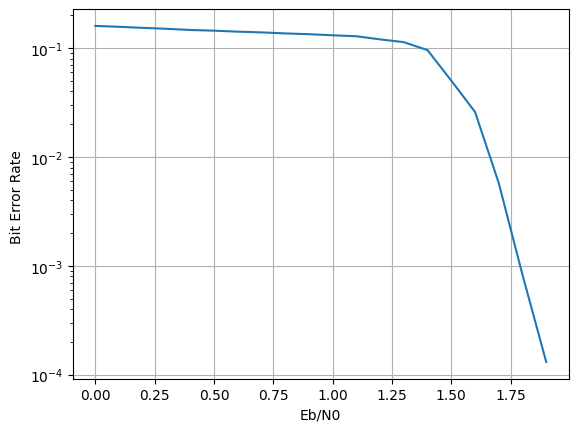

<Figure size 640x480 with 0 Axes>

In [16]:
filename = os.path.splitext(decoder_name)[0].replace('.','').replace('_config','')+'_'+timestr
pathname = os.path.join('BER_Results', filename.replace('.', ''))
os.makedirs(os.path.dirname(os.path.join(pathname,' ')), exist_ok=True)


#Plot
plt.semilogy(EbN0_dB_vector,BER_vector)
plt.xlabel('Eb/N0')
plt.ylabel('Bit Error Rate ')
plt.grid(True)
plt.show()

np.savez(os.path.join(pathname,'BER_results'), EbN0_dB_vector=EbN0_dB_vector, BER_vector=BER_vector)

plt.savefig(os.path.join(pathname,'BER_figure.pgf'))
plt.savefig(os.path.join(pathname,'BER_figure.pdf'))

res_dict = {"EbN0_dB_vector" : EbN0_dB_vector, "BER_vector":BER_vector
    , "decoder_name":decoder_name}

sio.savemat(os.path.join(pathname,'BER_results.mat'),res_dict)

### Neural decoder

In [55]:
H_filename = '8000.4000.3.483.alist'
code = load_code(H_filename)
H = code.H
G = code.G
var_degrees = code.var_degrees
chk_degrees = code.chk_degrees
num_edges = code.num_edges
u = code.u
d = code.d
n = code.n
m = code.m
k = code.k

KeyboardInterrupt: 

In [ ]:
def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in tqdm(loader, desc='Train batch #', leave=False):
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        # print(model_input[0], model_output[0])
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
        # calculate grad, upd weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc
                        
def epoch_test(loader, clf, criterion):
    clf.eval()
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in tqdm(loader, desc='Test batch #', leave=False):
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)

    return avg_loss, avg_acc

def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in trange(n_epochs):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(clf.W_cv[0,:5])
        if (np.mod(epoch+1,1)==0):
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
                  f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

## Regular Min-Sum decoder

In [23]:
class Min_Sum_Decoder_class_irregular:
    """This class implements an Min-Sum decoder
    """

    def __init__(self, filename, imax_, cardinality_T_channel_,msg_at_time_):

        # initialize parameters
        self.H = self.load_check_mat(filename)

        self.imax = imax_

        # Quantizer parameters
        self.cardinality_T_channel = cardinality_T_channel_

        # analyze the H matrix and set all decoder variables
        self.degree_checknode_nr = ((self.H_sparse).sum(1)).astype(np.int).A[:, 0]  # which check node has which degree?

        self.degree_varnode_nr = ((self.H_sparse).sum(0)).astype(np.int).A[0,
                                 :]  # which variable node has which degree?
        self.N_v = self.H.shape[1]  # How many variable nodes are present?
        self.N_c = self.H.shape[0]  # How many checknodes are present?

        self.d_c_max = self.degree_checknode_nr.max()
        self.d_v_max = self.degree_varnode_nr.max()

        self.codeword_len = self.H.shape[1]
        row_sum = self.H.sum(0)
        col_sum = self.H.sum(1)
        d_v_dist_val = np.unique(row_sum)
        d_v_dist = np.zeros(int(d_v_dist_val.max()))

        for d_v in np.sort(d_v_dist_val).astype(np.int):
            d_v_dist[d_v - 1] = (row_sum == d_v).sum()
        d_v_dist = d_v_dist / d_v_dist.sum()

        d_c_dist_val = np.unique(col_sum)
        d_c_dist = np.zeros(int(d_c_dist_val.max()))

        for d_c in np.sort(d_c_dist_val).astype(np.int):
            d_c_dist[d_c - 1] = (col_sum == d_c).sum()

        d_c_dist = d_c_dist / d_c_dist.sum()
        nom = np.dot(d_v_dist, np.arange(d_v_dist_val.max()) + 1)
        den = np.dot(d_c_dist, np.arange(d_c_dist_val.max()) + 1)

        self.R_c = 1 - nom / den

        self.data_len = (self.R_c * self.codeword_len).astype(int)

        self.msg_at_time = msg_at_time_
        self.map_node_connections()


    def load_sparse_csr(self, filename):
        loader = np.load(filename)
        return sci.sparse.csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                              shape=loader['shape'])

    def load_check_mat(self, filename):
        if filename.endswith('.npy') or filename.endswith('.npz'):
            if filename.endswith('.npy'):
                H = np.load(filename)
                self.H_sparse = sci.sparse.csr_matrix(H)
            else:
                self.H_sparse = self.load_sparse_csr(filename)
                H = self.H_sparse.toarray()
        else:
            arrays = [np.array(list(map(int, line.split()))) for line in open(filename)]
            H = self.alistToNumpy(arrays)
            self.H_sparse = sci.sparse.csr_matrix(H)
        return H

    def alistToNumpy(self, lines):
        """Converts a parity-check matrix in AList format to a 0/1 numpy array. The argument is a
       list-of-lists corresponding to the lines of the AList format, already parsed to integers
        if read from a text file.
        The AList format is introduced on http://www.inference.phy.cam.ac.uk/mackay/codes/alist.html.
        This method supports a "reduced" AList format where lines 3 and 4 (containing column and row
        weights, respectively) and the row-based information (last part of the Alist file) are omitted.
        Example:
             >>> alistToNumpy([[3,2], [2, 2], [1,1,2], [2,2], [1], [2], [1,2], [1,2,3,4]])
            array([[1, 0, 1],
                  [0, 1, 1]])
        """

        nCols, nRows = lines[0]
        if len(lines[2]) == nCols and len(lines[3]) == nRows:
            startIndex = 4
        else:
            startIndex = 2
        matrix = np.zeros((nRows, nCols), dtype=np.int)
        for col, nonzeros in enumerate(lines[startIndex:startIndex + nCols]):
            for rowIndex in nonzeros:
                if rowIndex != 0:
                    matrix[rowIndex - 1, col] = 1

        return matrix

    def map_node_connections(self):
        """ The overall idea of this function is to store the connections between var- and check nodes in a new structure
        namely two vectors. This vectors are called inboxes, because the entries should be seen as memory for incoming
        messages. Therefore it is important to track which check node output rights in which var node input and vince
        versa. """

        self.inbox_memory_start_checknodes = np.append([0], np.cumsum(self.degree_checknode_nr[:-1]) ).astype(np.int)
        self.inbox_memory_start_varnodes = np.append([0], np.cumsum(self.degree_varnode_nr[:-1]) ).astype(np.int)

        # At first it is determined which check node delivers to which var node
        # This information is encoded in the non-zero columns of each row
        # non-zero return the indices in the desired way.

        self.customers_checknode_nr = self.H_sparse.indices

        # Now it is determined which var node delivers to which check node
        # This information is encoded in the non-zero rows of each column
        # non-zero return the indices in the desired way.

        self.customers_varnode_nr = (self.H_sparse.tocsc() ).indices

        # now we now the connections but, since one node has multiple inputs the node number is node enough.
        # An additional offset vector needs to be defined. If one node was already connected, then the memory box is
        # filled. Performing cumsum on the rows only allows to generate this offset vector at check nodes destinations.

        H_copy = self.H_sparse.tocsc().copy()
        for i in range(self.N_v):
            H_copy.data[H_copy.indptr[i] : H_copy.indptr[i+1] ] = \
                np.arange(H_copy.indptr[i+1]-H_copy.indptr[i])

        self.offset_at_dest_checknodes = H_copy.tocsr().data
        self.target_memory_cells_checknodes = (self.inbox_memory_start_varnodes[self.customers_checknode_nr] + \
                                              self.offset_at_dest_checknodes).astype(np.int)

        H_copy = self.H_sparse.copy()
        for i in range(self.N_c):
            H_copy.data[H_copy.indptr[i] : H_copy.indptr[i+1] ] = \
                np.arange(H_copy.indptr[i+1]-H_copy.indptr[i])

        self.offset_at_dest_varnodes = H_copy.tocsc().data

        self.target_memory_cells_varnodes = (self.inbox_memory_start_checknodes[self.customers_varnode_nr] + \
                                            self.offset_at_dest_varnodes).astype(np.int)


        self.inbox_memory_checknodes = np.zeros((self.degree_checknode_nr.sum().astype(np.int),self.msg_at_time))
        self.inbox_memory_varnodes = np.zeros((self.degree_varnode_nr.sum().astype(np.int),self.msg_at_time))
        self.memory_channel_values = np.zeros(self.N_v)


    def init_OpenCL_decoding(self,msg_at_time_, context_=False):
        if not context_:
            self.context = cl.create_some_context()
        else:
            self.context = context_
        path = os.path.split(os.path.abspath("__file__"))

        kernelsource = open(os.path.join(path[0], "kernels_min_and_BP.cl")).read()
        tpl = Template(kernelsource)
        rendered_tp = tpl.render(cn_degree=self.d_c_max, vn_degree=self.d_v_max, msg_at_time=msg_at_time_)

        self.program = cl.Program(self.context, str(rendered_tp)).build()

        self.queue = cl.CommandQueue(self.context)

        self.inbox_memory_start_varnodes_buffer = cl_array.to_device(self.queue,
                                                                self.inbox_memory_start_varnodes.astype(np.int32))

        self.inbox_memory_start_checknodes_buffer = cl_array.to_device(self.queue,
                                                                  self.inbox_memory_start_checknodes.astype(np.int32))

        self.degree_varnode_nr_buffer = cl_array.to_device(self.queue, self.degree_varnode_nr.astype(np.int32))

        self.degree_checknode_nr_buffer = cl_array.to_device(self.queue, self.degree_checknode_nr.astype(np.int32))

        self.target_memorycells_varnodes_buffer = cl_array.to_device(self.queue,
                                                                self.target_memory_cells_varnodes.astype(np.int32))
        self.target_memorycells_checknodes_buffer = cl_array.to_device(self.queue,
                                                                  self.target_memory_cells_checknodes.astype(np.int32))


        self.checknode_inbox_buffer = cl_array.empty(self.queue, self.inbox_memory_checknodes.shape, dtype=np.float64)

        self.varnode_inbox_buffer = cl_array.empty(self.queue, self.inbox_memory_varnodes.shape, dtype=np.float64)

        self.syndrom_buffer = cl_array.empty(self.queue,
            (self.degree_checknode_nr.shape[0], self.inbox_memory_varnodes.shape[-1]), dtype=np.int32)

        self.krnl = get_sum_kernel(self.context, None,
                                   dtype_in=self.varnode_inbox_buffer.dtype)  # varnode_output_buffer.dtype )


        # define programs
        self.send_prog = self.program.send_channel_values_to_checknode_inbox

        self.varnode_update_prog = self.program.varnode_update

        self.checknode_update_prog_min_sum = self.program.checknode_update_minsum

        self.calc_syndrom_prog = self.program.calc_syndrome

        self.varoutput_prog = self.program.calc_varnode_output


    def decode_OpenCL_min_sum(self, received_blocks,buffer_in=False,return_buffer=False):
        # Set up OpenCL
        if buffer_in:
            channel_values_buffer = received_blocks
        else:
            channel_values_buffer = cl_array.to_device(self.queue,received_blocks.astype(np.float64))

        varnode_output_buffer = cl_array.empty(self.queue, received_blocks.shape, dtype=np.float64)


        self.send_prog(self.queue, received_blocks.shape, None,
                  channel_values_buffer.data,
                  self.inbox_memory_start_varnodes_buffer.data,
                  self.degree_varnode_nr_buffer.data,
                  self.target_memorycells_varnodes_buffer.data,
                  self.checknode_inbox_buffer.data)
        self.queue.finish()
        syndrome_zero = False
        i_num = 1


        while (i_num<self.imax) and (not syndrome_zero):

            local_size = None

            self.checknode_update_prog_min_sum(self.queue, (self.degree_checknode_nr.shape[0], received_blocks[:,np.newaxis].shape[-1]), None,
                                   self.checknode_inbox_buffer.data,
                                   self.inbox_memory_start_checknodes_buffer.data,
                                   self.degree_checknode_nr_buffer.data,
                                   self.target_memorycells_checknodes_buffer.data,
                                   self.varnode_inbox_buffer.data)

            self.queue.finish()
            self.varnode_update_prog(self.queue, received_blocks.shape , None,
                                channel_values_buffer.data,
                                self.varnode_inbox_buffer.data,
                                self.inbox_memory_start_varnodes_buffer.data,
                                self.degree_varnode_nr_buffer.data,
                                self.target_memorycells_varnodes_buffer.data,
                                self.checknode_inbox_buffer.data)

            self.calc_syndrom_prog(self.queue, (self.degree_checknode_nr.shape[0], received_blocks[:,np.newaxis].shape[-1]), None,
                                      self.checknode_inbox_buffer.data,
                                      self.inbox_memory_start_checknodes_buffer.data,
                                      self.degree_checknode_nr_buffer.data,
                                      self.syndrom_buffer.data)


            if cl_array.sum(self.syndrom_buffer).get() == 0:
                syndrome_zero =True


            i_num += 1


        self.varoutput_prog(self.queue, received_blocks.shape , None,
                            channel_values_buffer.data,
                            self.varnode_inbox_buffer.data,
                            self.inbox_memory_start_varnodes_buffer.data,
                            self.degree_varnode_nr_buffer.data,
                            varnode_output_buffer.data)
        self.queue.finish()
        if return_buffer:
            return varnode_output_buffer
        else:
            output_values = varnode_output_buffer.get()
            return output_values


    def return_errors_all_zero(self, varnode_output_buffer):

        # only consider first systematic bits which are R_c * N_var

        errors = self.krnl((varnode_output_buffer[:self.data_len].__lt__( 0 ).astype(np.float64))).get()
        return errors


    def discrete_cn_operation(self,vec_y_c,iter_):

        d_c_cur = vec_y_c.shape[1]+1

        t_lm1 = vec_y_c[:, 0]
        for l in range(d_c_cur - 2):
            t_lm1 = np.sign(vec_y_c[:,l + 1] * t_lm1) * \
                                np.minimum(np.sign(t_lm1) * t_lm1,np.sign(vec_y_c[:,l + 1]) * vec_y_c[:,l + 1])

        node_output_msg = t_lm1
        return node_output_msg

    def discrete_vn_operation(self, vec_y_v, iter_):

        t_lm1 = vec_y_v[:, 0]

        for l in range(vec_y_v.shape[1]- 1):
            t_lm1 = vec_y_v[:, l + 1] + t_lm1

        node_output_msg = t_lm1
        return node_output_msg

    def decode_on_host(self,channel_values_):

        self.memory_channel_values = channel_values_
        d_v_degrees = np.unique(self.degree_varnode_nr)
        d_c_degrees = np.unique(self.degree_checknode_nr)
        for d_v in d_v_degrees:
            var_node_inds = self.degree_varnode_nr == d_v
            start_idx_var = self.inbox_memory_start_varnodes[var_node_inds]
            ind_mat_var = start_idx_var[:, np.newaxis] + np.arange(d_v)
            channel_val_mat = np.kron(self.memory_channel_values[var_node_inds, np.newaxis],
                                      np.ones((d_v, 1)))

            self.inbox_memory_checknodes[:, 0][self.target_memory_cells_varnodes[ind_mat_var]] = \
                channel_val_mat

        for iter in range(self.imax):

            for d_c in d_c_degrees:
                check_node_inds = self.degree_checknode_nr == d_c
                start_idx_check = self.inbox_memory_start_checknodes[check_node_inds]
                ind_mat_check = start_idx_check[:, np.newaxis] + np.arange(d_c)

                all_messages = self.inbox_memory_checknodes[ind_mat_check]
                m = np.kron(np.arange(d_c)[:, np.newaxis],
                            np.ones(d_c))
                reduced = all_messages[:, m.transpose()[(1 - np.eye(d_c)).astype(bool)].astype(int)]
                reduced = np.reshape(reduced, (-1, d_c - 1))

                customers_check = np.reshape(self.target_memory_cells_checknodes[ind_mat_check], (-1, 1))[:, 0]
                self.inbox_memory_varnodes[customers_check, 0] = self.discrete_cn_operation(reduced, iter)


            for d_v in d_v_degrees:
                var_node_inds = self.degree_varnode_nr == d_v
                start_idx_var = self.inbox_memory_start_varnodes[var_node_inds]
                ind_mat_var = start_idx_var[:, np.newaxis] + np.arange(d_v)
                channel_val_mat = np.kron(self.memory_channel_values[var_node_inds],
                                          np.ones((d_v, 1))).astype(int)

                all_messages = self.inbox_memory_varnodes[ind_mat_var]

                m = np.kron(np.arange(d_v)[:, np.newaxis], np.ones(d_v))

                reduced = all_messages[:, m.transpose()[(1 - np.eye(d_v)).astype(bool)].astype(int)]
                reduced = np.reshape(reduced, (-1, d_v - 1))

                customers_var = np.reshape(self.target_memory_cells_varnodes[ind_mat_var], (-1, 1))

                self.inbox_memory_checknodes[:, 0][customers_var] = self.discrete_vn_operation(
                    np.hstack((channel_val_mat, reduced)), iter)



        output_vector = np.zeros(self.N_v)
        for d_v in d_v_degrees:
            var_node_inds = self.degree_varnode_nr == d_v
            start_idx_var = self.inbox_memory_start_varnodes[var_node_inds]
            ind_mat_var = start_idx_var[:, np.newaxis] + np.arange(d_v)

            all_messages = self.inbox_memory_varnodes[ind_mat_var]
            output_vector[var_node_inds] = self.discrete_vn_operation(
                 np.hstack((self.memory_channel_values[var_node_inds], all_messages[:, :, 0])), self.imax - 1)

        return output_vector

In [27]:
np.seterr(all='raise')

# Load stored data
filepath ="8000.4000.3.483.alist"

# Human choice
AD_max_abs = 3
cardinality_Y_channel = 2000
cardinality_T_channel = 16
cardinality_T_decoder_ops = 16
msg_at_time = 400
min_errors = 1500

imax =50
N_var = 8000


In [30]:
decoder_name = 'minsum_'+str(cardinality_T_decoder_ops)
timestr = time.strftime("%y%m%d-%H%M")

filename = os.path.splitext(decoder_name)[0].replace('.','').replace('_config','')+'_'+timestr
pathname = os.path.join('BER_Results', filename.replace('.', ''))
os.makedirs(os.path.dirname(os.path.join(pathname,' ')), exist_ok=True)


#sets the start EbN0_dB value
EbN0_dB_max_value = 2.2

#simulation runs until this BER is achieved
target_error_rate=1e-6
BER_go_on_in_smaller_steps=1e-6

#in steps of size..
EbN0_dB_normal_stepwidth=0.1
EbN0_dB_small_stepwidth=0.05

# start EbN0 simulation
EbN0_dB = 0
EbN0_dB_ind = 0
BER_vector = np.array([0.])
EbN0_dB_vector = np.array([EbN0_dB])
ready = False
NR_BLOCKS_PER_CONTROL_MSG = 100

transi = LDPC_BPSK_Transmitter(filepath, msg_at_time)
decodi = Min_Sum_Decoder_class_irregular(filepath, imax, cardinality_T_channel, msg_at_time)

C:\Users\admin\AppData\Local\Temp\ipykernel_7280\2369990824.py:68: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  matrix = np.zeros((nRows, nCols), dtype=np.int)
C:\Users\admin\AppData\Local\Temp\ipykernel_7280\3384563453.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

Not invertible Matrix


C:\Users\admin\AppData\Local\Temp\ipykernel_7280\2369990824.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.degree_checknode_nr = ((self.H_sparse).sum(1)).astype(np.int).A[:, 0]  # which check node has which degree?
C:\Users\admin\AppData\Local\Temp\ipykernel_7280\2369990824.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify 

In [31]:
while not ready:
    EbN0_dB_ind += EbN0_dB_ind
    EbN0_dB = EbN0_dB_vector[-1]

    sigma_n2 = 10**(-EbN0_dB/10) / (2*transi.R_c)

    quanti = AWGN_Channel_Quantizer(sigma_n2, AD_max_abs, cardinality_T_channel, cardinality_Y_channel)
    quanti.init_OpenCL_quanti(N_var,msg_at_time,return_buffer_only=True)
    decodi.init_OpenCL_decoding(msg_at_time,quanti.context)


    errors = 0
    errors1 = 0

    transmitted_blocks = 0
    # transmit
    start = time.time()
    while errors < min_errors:


        rec_data_quantized = quanti.quantize_direct_OpenCL_LLR(N_var, msg_at_time)
        decoded_mat = decodi.decode_OpenCL_min_sum(rec_data_quantized,buffer_in=True,return_buffer=True)
        errors += decodi.return_errors_all_zero(decoded_mat)
        transmitted_blocks += + msg_at_time

        if np.mod(transmitted_blocks, NR_BLOCKS_PER_CONTROL_MSG) == 0:
            time_so_far = time.time()-start
            time_per_error = (time_so_far / (errors+1)) #+1 to avoid devide by 0 errors
            estim_minutes_left = ((min_errors * time_per_error) - time_so_far) / 60

            print('EbN0_dB=', EbN0_dB, ', '
                  'errors=', errors,
                  ' elapsed time this run=', time_so_far,
                  ' BER_estimate=','{:.2e}'.format( (errors / (transi.R_c*transmitted_blocks * N_var))),
                  ' datarate_Bps =', '{:.2e}'.format(  (transi.R_c*transmitted_blocks * N_var) / time_so_far),
                  ' estim_minutes_left=',estim_minutes_left)

    end = time.time()

    BER_vector[-1] = errors / (transi.R_c*transmitted_blocks * N_var)
    spent = end-start
    datarate_Bps = (transi.R_c*transmitted_blocks * N_var) / spent
    print(EbN0_dB_vector[-1], '{:.2e}'.format(BER_vector[-1]), ' Bitrate:','{:.2e}'.format(datarate_Bps) )
    np.savez(os.path.join(pathname, 'BER_results'), EbN0_dB_vector=EbN0_dB_vector, BER_vector=BER_vector)

    if (BER_vector[-1] > target_error_rate) and (EbN0_dB < EbN0_dB_max_value):
        if BER_vector[-1] < BER_go_on_in_smaller_steps:
            EbN0_dB_vector = np.append(EbN0_dB_vector, EbN0_dB_vector[-1] + EbN0_dB_small_stepwidth)
        else:
            EbN0_dB_vector = np.append(EbN0_dB_vector, EbN0_dB_vector[-1] + EbN0_dB_normal_stepwidth)

        BER_vector = np.append(BER_vector, 0)
    else:
        ready = True


Run: [######################################################################] 100.0% 5 / 5    

[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL HD Graphics' at 0x1f52c84b2c0>]
EbN0_dB= 0 , errors= 268829.0  elapsed time this run= 4.5215089321136475  BER_estimate= 1.68e-01  datarate_Bps = 3.54e+05  estim_minutes_left= -0.07493800188607058
0 1.68e-01  Bitrate: 3.54e+05
Run: [######################################################################] 100.0% 5 / 5    

[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL HD Graphics' at 0x1f52c84b2c0>]
EbN0_dB= 0.1 , errors= 260471.0  elapsed time this run= 4.364115476608276  BER_estimate= 1.63e-01  datarate_Bps = 3.67e+05  estim_minutes_left= -0.07231639185838264
0.1 1.63e-01  Bitrate: 3.67e+05
Run: [######################################################################] 100.0% 5 / 5    

[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL HD Graphics' at 0x1f52c84b2c0>]
EbN0_dB= 0.2 , errors= 2531

Run: [######################################################################] 100.0% 5 / 5    

[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL HD Graphics' at 0x1f52c84b2c0>]
EbN0_dB= 2.0000000000000004 , errors= 490.0  elapsed time this run= 4.031179666519165  BER_estimate= 3.06e-04  datarate_Bps = 3.97e+05  estim_minutes_left= 0.13806721939979083
EbN0_dB= 2.0000000000000004 , errors= 2129.0  elapsed time this run= 8.099420547485352  BER_estimate= 6.65e-04  datarate_Bps = 3.95e+05  estim_minutes_left= -0.0399267210087306
2.0000000000000004 6.65e-04  Bitrate: 3.95e+05
Run: [######################################################################] 100.0% 5 / 5    

[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL HD Graphics' at 0x1f52c84b2c0>]
EbN0_dB= 2.1000000000000005 , errors= 109.0  elapsed time this run= 4.057034254074097  BER_estimate= 6.81e-05  datarate_Bps = 3.94e+05  estim_minutes_left= 0.8544360019943932
EbN0_dB= 2.1000000000000005 , errors=

EbN0_dB= 2.2000000000000006 , errors= 204.0  elapsed time this run= 101.59487891197205  BER_estimate= 3.54e-06  datarate_Bps = 5.67e+05  estim_minutes_left= 10.696371397642586
EbN0_dB= 2.2000000000000006 , errors= 204.0  elapsed time this run= 103.73788142204285  BER_estimate= 3.45e-06  datarate_Bps = 5.71e+05  estim_minutes_left= 10.921996458662234
EbN0_dB= 2.2000000000000006 , errors= 204.0  elapsed time this run= 105.64467430114746  BER_estimate= 3.36e-06  datarate_Bps = 5.76e+05  estim_minutes_left= 11.122752294307803
EbN0_dB= 2.2000000000000006 , errors= 204.0  elapsed time this run= 107.94251871109009  BER_estimate= 3.27e-06  datarate_Bps = 5.78e+05  estim_minutes_left= 11.364679815517208
EbN0_dB= 2.2000000000000006 , errors= 204.0  elapsed time this run= 110.1053831577301  BER_estimate= 3.19e-06  datarate_Bps = 5.81e+05  estim_minutes_left= 11.592396031647192
EbN0_dB= 2.2000000000000006 , errors= 433.0  elapsed time this run= 114.23978924751282  BER_estimate= 6.60e-06  datarate_

EbN0_dB= 2.2000000000000006 , errors= 1073.0  elapsed time this run= 216.74206018447876  BER_estimate= 8.08e-06  datarate_Bps = 6.13e+05  estim_minutes_left= 1.4328385729141522
EbN0_dB= 2.2000000000000006 , errors= 1228.0  elapsed time this run= 220.76393508911133  BER_estimate= 9.14e-06  datarate_Bps = 6.09e+05  estim_minutes_left= 0.8113239274362514
EbN0_dB= 2.2000000000000006 , errors= 1228.0  elapsed time this run= 222.72871160507202  BER_estimate= 9.03e-06  datarate_Bps = 6.11e+05  estim_minutes_left= 0.8185446276779837
EbN0_dB= 2.2000000000000006 , errors= 1228.0  elapsed time this run= 225.17696809768677  BER_estimate= 8.92e-06  datarate_Bps = 6.11e+05  estim_minutes_left= 0.8275421528949437
EbN0_dB= 2.2000000000000006 , errors= 1340.0  elapsed time this run= 229.19428730010986  BER_estimate= 9.63e-06  datarate_Bps = 6.07e+05  estim_minutes_left= 0.45291935969074665
EbN0_dB= 2.2000000000000006 , errors= 1340.0  elapsed time this run= 231.2379710674286  BER_estimate= 9.52e-06  da

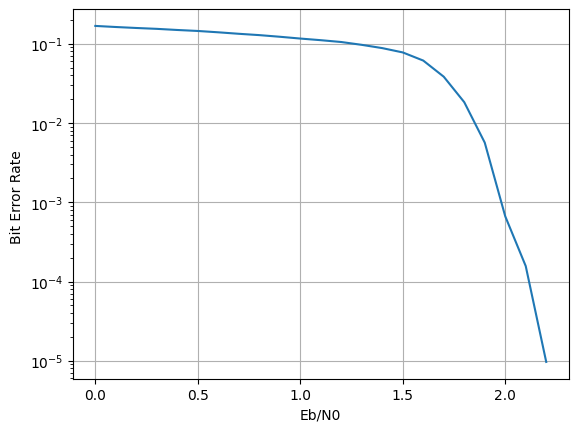

<Figure size 640x480 with 0 Axes>

In [32]:
#Plot
plt.figure()
plt.semilogy(EbN0_dB_vector,BER_vector)
plt.xlabel('Eb/N0')
plt.ylabel('Bit Error Rate ')
plt.grid(True)
plt.show()

np.savez(os.path.join(pathname,'BER_results'), EbN0_dB_vector=EbN0_dB_vector, BER_vector=BER_vector)

plt.savefig(os.path.join(pathname,'BER_figure.pgf'))
plt.savefig(os.path.join(pathname,'BER_figure.pdf'))

res_dict = {"EbN0_dB_vector" : EbN0_dB_vector, "BER_vector":BER_vector
    , "decoder_name":decoder_name}

sio.savemat(os.path.join(pathname,'BER_results.mat'),res_dict)